# Forecast for Energy Mix

## 1.Setup

In [1]:
from IPython.display import clear_output

In [2]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas
!pip install skforecast
# !pip install scikit-learn==1.2
# !pip install pycaret

clear_output()

In [3]:
# import sklearn
# print(sklearn.__version__)

In [4]:
import openmeteo_requests
import requests_cache
from retry_requests import retry
import time

# Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openmeteo_requests
import requests_cache
from retry_requests import retry
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.utils import save_forecaster
from skforecast.datasets import fetch_dataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
# from pycaret.regression import *

# Import libraries
import requests
from datetime import datetime, timedelta, date
import openmeteo_requests
import requests_cache
from retry_requests import retry
import pytz


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
google_drive_path = "/content/drive/MyDrive/LINC/"

In [6]:
# Backtesting with custom metric
# ==============================================================================
def custom_mape(y_true, y_pred):
    mape = (np.abs(y_pred - y_true) / np.abs(y_true)).map(lambda x: 0 if math.isnan(x) else x)
    mape = mape.map(lambda x: 1 if math.isinf(x) else x)
    return np.mean(mape)

In [7]:
# Backtesting with custom metric
# ==============================================================================
def custom_smape(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))).map(lambda x: 0 if math.isnan(x) else x))

## 2.Get historical weather data

In [8]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [9]:
def get_weather_historical(lati, longi, suffix):

  url = "https://archive-api.open-meteo.com/v1/archive"

  params = {
	  "latitude": lati,
	  "longitude": longi,
	  "start_date": "2023-01-01",
	  "end_date": "2024-05-30",
    "hourly": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation", "rain", "pressure_msl", "surface_pressure", "cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m", "wind_gusts_10m", "is_day", "sunshine_duration", "shortwave_radiation", "direct_radiation", "diffuse_radiation", "direct_normal_irradiance", "terrestrial_radiation", "shortwave_radiation_instant", "direct_radiation_instant", "diffuse_radiation_instant", "direct_normal_irradiance_instant", "terrestrial_radiation_instant"],
	  "timezone": "Europe/Warsaw"
  }

  responses = openmeteo.weather_api(url, params=params)

  # Process first location. Add a for-loop for multiple locations or weather models
  response = responses[0]

  # Process hourly data. The order of variables needs to be the same as requested.
  hourly = response.Hourly()
  hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
  hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
  hourly_apparent_temperature = hourly.Variables(2).ValuesAsNumpy()
  hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
  hourly_rain = hourly.Variables(4).ValuesAsNumpy()
  hourly_pressure_msl = hourly.Variables(5).ValuesAsNumpy()
  hourly_surface_pressure = hourly.Variables(6).ValuesAsNumpy()
  hourly_cloud_cover = hourly.Variables(7).ValuesAsNumpy()
  hourly_cloud_cover_low = hourly.Variables(8).ValuesAsNumpy()
  hourly_cloud_cover_mid = hourly.Variables(9).ValuesAsNumpy()
  hourly_cloud_cover_high = hourly.Variables(10).ValuesAsNumpy()
  hourly_wind_speed_10m = hourly.Variables(11).ValuesAsNumpy()
  hourly_wind_speed_100m = hourly.Variables(12).ValuesAsNumpy()
  hourly_wind_direction_10m = hourly.Variables(13).ValuesAsNumpy()
  hourly_wind_direction_100m = hourly.Variables(14).ValuesAsNumpy()
  hourly_wind_gusts_10m = hourly.Variables(15).ValuesAsNumpy()
  hourly_is_day = hourly.Variables(16).ValuesAsNumpy()
  hourly_sunshine_duration = hourly.Variables(17).ValuesAsNumpy()
  hourly_shortwave_radiation = hourly.Variables(18).ValuesAsNumpy()
  hourly_direct_radiation = hourly.Variables(19).ValuesAsNumpy()
  hourly_diffuse_radiation = hourly.Variables(20).ValuesAsNumpy()
  hourly_direct_normal_irradiance = hourly.Variables(21).ValuesAsNumpy()
  hourly_terrestrial_radiation = hourly.Variables(22).ValuesAsNumpy()
  hourly_shortwave_radiation_instant = hourly.Variables(23).ValuesAsNumpy()
  hourly_direct_radiation_instant = hourly.Variables(24).ValuesAsNumpy()
  hourly_diffuse_radiation_instant = hourly.Variables(25).ValuesAsNumpy()
  hourly_direct_normal_irradiance_instant = hourly.Variables(26).ValuesAsNumpy()
  hourly_terrestrial_radiation_instant = hourly.Variables(27).ValuesAsNumpy()

  hourly_data = {"date": pd.date_range(
	  start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	  end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	  freq = pd.Timedelta(seconds = hourly.Interval()),
	  inclusive = "left"
  )}

  hourly_data["temperature_2m"] = hourly_temperature_2m
  hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
  hourly_data["apparent_temperature"] = hourly_apparent_temperature
  hourly_data["precipitation"] = hourly_precipitation
  hourly_data["rain"] = hourly_rain
  hourly_data["pressure_msl"] = hourly_pressure_msl
  hourly_data["surface_pressure"] = hourly_surface_pressure
  hourly_data["cloud_cover"] = hourly_cloud_cover
  hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
  hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
  hourly_data["cloud_cover_high"] = hourly_cloud_cover_high
  hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
  hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
  hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
  hourly_data["wind_direction_100m"] = hourly_wind_direction_100m
  hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
  hourly_data["is_day"] = hourly_is_day
  hourly_data["sunshine_duration"] = hourly_sunshine_duration
  hourly_data["shortwave_radiation"] = hourly_shortwave_radiation
  hourly_data["direct_radiation"] = hourly_direct_radiation
  hourly_data["diffuse_radiation"] = hourly_diffuse_radiation
  hourly_data["direct_normal_irradiance"] = hourly_direct_normal_irradiance
  hourly_data["terrestrial_radiation"] = hourly_terrestrial_radiation
  hourly_data["shortwave_radiation_instant"] = hourly_shortwave_radiation_instant
  hourly_data["direct_radiation_instant"] = hourly_direct_radiation_instant
  hourly_data["diffuse_radiation_instant"] = hourly_diffuse_radiation_instant
  hourly_data["direct_normal_irradiance_instant"] = hourly_direct_normal_irradiance_instant
  hourly_data["terrestrial_radiation_instant"] = hourly_terrestrial_radiation_instant

  hourly_dataframe = pd.DataFrame(data = hourly_data)
  hourly_dataframe['date'] = hourly_dataframe['date'].dt.tz_convert('Europe/Warsaw')

  # Adding suffix to columns 2 to 4
  for col in hourly_dataframe.columns[1:]:  # Columns 2 to end
    hourly_dataframe.rename(columns={col: col + suffix}, inplace=True)

  return hourly_dataframe
  # hourly_dataframe

In [10]:
# Wind farms
# ------------
# https://www.thewindpower.net/country_zones_en_27_poland.php
df_wind1 = get_weather_historical(53.4658, 15.1823, '_wind1') #Zachodniopomorskie
df_wind2 = get_weather_historical(54.2944, 18.1531, '_wind2') # Pomorskie
df_wind3 = get_weather_historical(52.28, 17.3523, "_wind3") # Wielkopolskie

time.sleep(60)

# PVs
# ----
# https://www.power-technology.com/data-insights/top-five-solar-pv-plants-in-operation-in-poland/
df_pv1 = get_weather_historical(52.0135, 18.63, "_pv1") # Turek Solar PV Park https://www.gem.wiki/Przykona_solar_farm
df_pv2 = get_weather_historical(52.0816, 18.6499, "_pv2") # Brudzew Solar PV Park https://www.gem.wiki/Brudzew_solar_farm
df_pv3 = get_weather_historical(52.6579, 14.882, "_pv3") # Witnica Solar PV Park https://www.gem.wiki/Witnica_solar_farm

time.sleep(60)

# Weather big cities
# ------------------
# https://www.statista.com/statistics/1455315/poland-largest-cities-by-population/
df_t1 = get_weather_historical(52.2297, 21.0122, "_t1") # warsaw
df_t2 = get_weather_historical(50.0647, 19.9450, "_t2") # krakow
df_t3 = get_weather_historical(54.3520, 18.6466, "_t3") # gdansk

df_weather_historical = df_wind1.merge(df_wind2, on='date', how='inner').\
                              merge(df_wind3, on='date', how='inner').\
                              merge(df_pv1, on='date', how='inner').\
                              merge(df_pv2, on='date', how='inner').\
                              merge(df_pv3, on='date', how='inner').\
                              merge(df_t1, on='date', how='inner').\
                              merge(df_t2, on='date', how='inner').\
                              merge(df_t3, on='date', how='inner')
df_weather_historical

date  temperature_2m_wind1  \
0     2022-12-31 23:00:00+01:00             14.409000   
1     2023-01-01 00:00:00+01:00             14.059000   
2     2023-01-01 01:00:00+01:00             13.609000   
3     2023-01-01 02:00:00+01:00             13.959001   
4     2023-01-01 03:00:00+01:00             14.759001   
...                         ...                   ...   
12379 2024-05-30 19:00:00+02:00             18.959000   
12380 2024-05-30 20:00:00+02:00             17.109001   
12381 2024-05-30 21:00:00+02:00             16.509001   
12382 2024-05-30 22:00:00+02:00             15.909000   
12383 2024-05-30 23:00:00+02:00             15.509001   

       relative_humidity_2m_wind1  apparent_temperature_wind1  \
0                       74.378571                    9.870138   
1                       71.860046                    9.284261   
2                       70.571175                    9.084556   
3                       66.229645                    9.059750   
4                       60.160999                    9.318270   
...                           ...                         ...   
12379                   69.064247                   17.708681   
12380                   85.233948                   17.118692   
12381                   90.269516                   16.833487   
12382                   89.066025                   15.589577   
12383                   88.457054                   15.197622   

       precipitation_wind1  rain_wind1  pressure_msl_wind1  \
0                      0.0         0.0         1008.400024   
1                      0.0         0.0         1008.700012   
2                      0.0         0.0         1008.400024   
3                      0.0         0.0         1008.900024   
4                      0.0         0.0         1008.799988   
...                    ...         ...                 ...   
12379                  1.6         1.6         1006.200012   
12380                  0.5         0.5         1005.599976   
12381                  0.0         0.0         1005.500000   
12382                  0.0         0.0         1005.500000   
12383                  0.0         0.0         1005.099976   

       surface_pressure_wind1  cloud_cover_wind1  cloud_cover_low_wind1  ...  \
0                  999.818298         100.000000                   65.0  ...   
1                 1000.105103          45.900002                   13.0  ...   
2                  999.794434          73.800003                    8.0  ...   
3                 1000.300537         100.000000                  100.0  ...   
4                 1000.225220         100.000000                   63.0  ...   
...                       ...                ...                    ...  ...   
12379              997.769775          93.600006                   30.0  ...   
12380              997.121277          31.800001                    1.0  ...   
12381              997.004578          38.700001                    0.0  ...   
12382              996.987122          30.300001                    1.0  ...   
12383              996.578613          33.000000                    0.0  ...   

       shortwave_radiation_t3  direct_radiation_t3  diffuse_radiation_t3  \
0                         0.0                  0.0                   0.0   
1                         0.0                  0.0                   0.0   
2                         0.0                  0.0                   0.0   
3                         0.0                  0.0                   0.0   
4                         0.0                  0.0                   0.0   
...                       ...                  ...                   ...   
12379                   231.0                127.0                 104.0   
12380                   111.0                 52.0                  59.0   
12381                    29.0                 11.0                  18.0   
12382                     0.0                  0.0                   0.0   
12383              

## 3.Combing with historical energy mix data

In [11]:
df_EnMix_historical = pd.read_csv(google_drive_path + "EnergyMix_PL_historical_estimated.csv")
df_EnMix_historical = df_EnMix_historical.dropna().reset_index(drop=True)
df_EnMix_historical['timestamp'] = pd.to_datetime(df_EnMix_historical['timestamp'], utc = True).dt.tz_convert('Europe/Warsaw')
df_EnMix_historical

timestamp      total      wind      oil       gas  \
0     2023-01-01 01:00:00+01:00  14444.438  5529.188  197.539  1006.358   
1     2023-01-01 02:00:00+01:00  13690.800  4250.700  209.640  1068.008   
2     2023-01-01 03:00:00+01:00  13440.763  3124.613  229.542  1169.399   
3     2023-01-01 04:00:00+01:00  13428.488  3486.663  221.073  1126.254   
4     2023-01-01 05:00:00+01:00  13642.538  4257.800  208.401  1061.696   
...                         ...        ...       ...      ...       ...   
12402 2024-05-31 20:00:00+02:00  16607.525   770.913  332.557  1694.207   
12403 2024-05-31 21:00:00+02:00  16673.713   966.775  341.910  1741.856   
12404 2024-05-31 22:00:00+02:00  16226.913  1327.963  332.145  1692.111   
12405 2024-05-31 23:00:00+02:00  14930.163  1568.638  298.033  1518.326   
12406 2024-06-01 00:00:00+02:00  13601.163  1495.450  270.000  1375.512   

            coal  biomass       pv    water  
0       7523.575        0    0.000  187.778  
1       7984.472        0    0.000  177.980  
2       8742.479        0    0.000  174.730  
3       8419.927        0    0.000  174.570  
4       7937.288        0    0.000  177.353  
...          ...      ...      ...      ...  
12402  12665.963        0  927.988  215.898  
12403  13022.189        0  384.225  216.758  
12404  12650.294        0   13.450  210.950  
12405  11351.074        0    0.000  194.092  
12406  10283.386        0    0.000  176.815  

[12407 rows x 9 columns]

In [12]:
df_model = pd.merge(df_weather_historical, df_EnMix_historical, how='left', left_on='date', right_on='timestamp').drop(columns = ['timestamp'])
df_model[['total', 'wind', 'oil',	'gas', 'coal', 'biomass', 'pv', 'water']] = \
df_model[['total', 'wind', 'oil',	'gas', 'coal', 'biomass', 'pv', 'water']].fillna(method='ffill')
df_model['dow'] = df_model['date'].dt.dayofweek
df_model['mmonth'] = df_model['date'].dt.month
df_model['hhour'] = df_model['date'].dt.hour
df_model = df_model.set_index('date')
df_model = df_model.asfreq('H')
df_model = df_model.sort_index().dropna(how = "any")
df_model

<ipython-input-12-e0d5a5ddb6af>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_model[['total', 'wind', 'oil',	'gas', 'coal', 'biomass', 'pv', 'water']].fillna(method='ffill')


temperature_2m_wind1  relative_humidity_2m_wind1  \
date                                                                          
2023-01-01 01:00:00+01:00             13.609000                   70.571175   
2023-01-01 02:00:00+01:00             13.959001                   66.229645   
2023-01-01 03:00:00+01:00             14.759001                   60.160999   
2023-01-01 04:00:00+01:00             15.259001                   56.099483   
2023-01-01 05:00:00+01:00             15.159000                   54.737705   
...                                         ...                         ...   
2024-05-30 19:00:00+02:00             18.959000                   69.064247   
2024-05-30 20:00:00+02:00             17.109001                   85.233948   
2024-05-30 21:00:00+02:00             16.509001                   90.269516   
2024-05-30 22:00:00+02:00             15.909000                   89.066025   
2024-05-30 23:00:00+02:00             15.509001                   88.457054   

                           apparent_temperature_wind1  precipitation_wind1  \
date                                                                         
2023-01-01 01:00:00+01:00                    9.084556                  0.0   
2023-01-01 02:00:00+01:00                    9.059750                  0.0   
2023-01-01 03:00:00+01:00                    9.318270                  0.0   
2023-01-01 04:00:00+01:00                    9.681547                  0.0   
2023-01-01 05:00:00+01:00                    9.710276                  0.0   
...                                               ...                  ...   
2024-05-30 19:00:00+02:00                   17.708681                  1.6   
2024-05-30 20:00:00+02:00                   17.118692                  0.5   
2024-05-30 21:00:00+02:00                   16.833487                  0.0   
2024-05-30 22:00:00+02:00                   15.589577                  0.0   
2024-05-30 23:00:00+02:00                   15.197622                  0.0   

                           rain_wind1  pressure_msl_wind1  \
date                                                        
2023-01-01 01:00:00+01:00         0.0         1008.400024   
2023-01-01 02:00:00+01:00         0.0         1008.900024   
2023-01-01 03:00:00+01:00         0.0         1008.799988   
2023-01-01 04:00:00+01:00         0.0         1009.200012   
2023-01-01 05:00:00+01:00         0.0         1009.400024   
...                               ...                 ...   
2024-05-30 19:00:00+02:00         1.6         1006.200012   
2024-05-30 20:00:00+02:00         0.5         1005.599976   
2024-05-30 21:00:00+02:00         0.0         1005.500000   
2024-05-30 22:00:00+02:00         0.0         1005.500000   
2024-05-30 23:00:00+02:00         0.0         1005.099976   

                           surface_pressure_wind1  cloud_cover_wind1  \
date                                                                   
2023-01-01 01:00:00+01:00              999.794434          73.800003   
2023-01-01 02:00:00+01:00             1000.300537         100.000000   
2023-01-01 03:00:00+01:00             1000.225220         100.000000   
2023-01-01 04:00:00+01:00             1000.636658         100.000000   
2023-01-01 05:00:00+01:00             1000.831787         100.000000   
...                                           ...                ...   
2024-05-30 19:00:00+02:00              997.769775          93.600006   
2024-05-30 20:00:00+02:00              997.121277          31.800001   
2024-05-30 21:00:00+02:00              997.004578          38.700001   
2024-05-30 22:00:00+02:00              996.987122          30.300001   
2024-05-30 23:00:00+02:00              996.578613          33.000000   

                           cloud_cover_low_wind1  cloud_cover_mid_wind1  ...  \
date                                                                     ...   
2023-01-01 01:00:00+01:00                    8.0                   61.0  ...   
2023-01-01 02

In [13]:
# df_train_1= df_wind_1[df_wind_1.index >= pd.Timestamp('2023-01-01', tz='Europe/Athens')]
df_train = df_model[df_model.index < pd.Timestamp('2024-01-01', tz='Europe/Warsaw')]
df_test = df_model[df_model.index >= pd.Timestamp('2024-01-01', tz='Europe/Warsaw')]

In [14]:
df_train.shape, df_test.shape

((8759, 263), (3623, 263))

## 4.Wind Model

<Axes: >

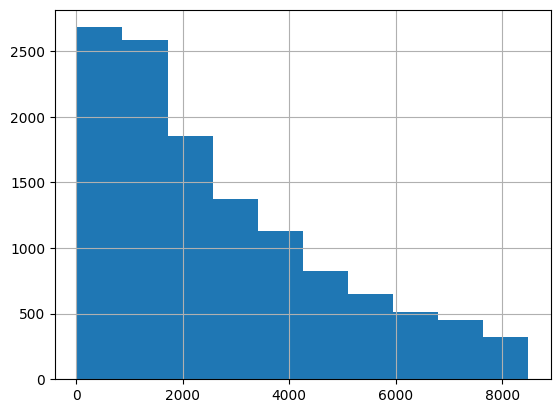

In [15]:
df_model['wind'].hist()

### 4.1. Recursive multi-step forecasting (with weather inputs from 3 wind farms)

#### 4.2.1. Random Forests

In [16]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['wind'],
                          exog                  = df_model[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                                                            'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                                                            'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

In [17]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1143947.5939666845
RMSE: 1069.5548578575504
MAE: 810.2478551476677
MAPE: 0.3469651805335328
Custom MAPE: 0.3469651805335328
Custom sMAPE: 0.16351196714156901


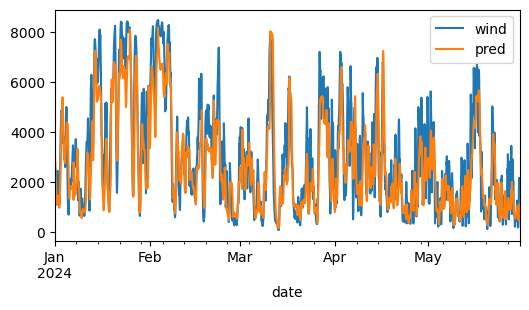

In [18]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['wind'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [19]:
df_test[df_test.wind < 100]

temperature_2m_wind1  relative_humidity_2m_wind1  \
date                                                                          
2024-03-13 12:00:00+01:00              9.559000                   82.689079   
2024-03-13 13:00:00+01:00             10.209001                   75.703537   
2024-03-13 15:00:00+01:00             11.459001                   60.832466   
2024-03-13 16:00:00+01:00             11.259001                   62.076550   
2024-03-13 17:00:00+01:00             10.609000                   69.982140   

                           apparent_temperature_wind1  precipitation_wind1  \
date                                                                         
2024-03-13 12:00:00+01:00                    7.321463                  0.2   
2024-03-13 13:00:00+01:00                    7.703632                  0.1   
2024-03-13 15:00:00+01:00                    8.756348                  0.0   
2024-03-13 16:00:00+01:00                    8.701024                  0.0   
2024-03-13 17:00:00+01:00                    8.778045                  0.0   

                           rain_wind1  pressure_msl_wind1  \
date                                                        
2024-03-13 12:00:00+01:00         0.2         1016.799988   
2024-03-13 13:00:00+01:00         0.1         1016.799988   
2024-03-13 15:00:00+01:00         0.0         1016.299988   
2024-03-13 16:00:00+01:00         0.0         1016.200012   
2024-03-13 17:00:00+01:00         0.0         1016.099976   

                           surface_pressure_wind1  cloud_cover_wind1  \
date                                                                   
2024-03-13 12:00:00+01:00             1007.999023          80.099998   
2024-03-13 13:00:00+01:00             1008.019043         100.000000   
2024-03-13 15:00:00+01:00             1007.561584          99.000000   
2024-03-13 16:00:00+01:00             1007.456360          67.799995   
2024-03-13 17:00:00+01:00             1007.337341          31.500000   

                           cloud_cover_low_wind1  cloud_cover_mid_wind1  ...  \
date                                                                     ...   
2024-03-13 12:00:00+01:00                   49.0                   60.0  ...   
2024-03-13 13:00:00+01:00                   98.0                   60.0  ...   
2024-03-13 15:00:00+01:00                  100.0                   15.0  ...   
2024-03-13 16:00:00+01:00                   74.0                    2.0  ...   
2024-03-13 17:00:00+01:00                   35.0                    0.0  ...   

                             wind      oil       gas       coal  biomass  \
date                                                                       
2024-03-13 12:00:00+01:00  93.288  392.248  1998.304  14939.406      0.0   
2024-03-13 13:00:00+01:00  93.050  394.812  2011.366  15037.058      0.0   
2024-03-13 15:00:00+01:00  90.813  399.664  2036.083  15221.842      0.0   
2024-03-13 16:00:00+01:00  80.138  420.238  2140.897  16005.442      0.0   
2024-03-13 17:00:00+01:00  96.088  439.534  2239.199  16740.348      0.0   

                                 pv    water  dow  mmonth  hhour  
date                                                              
2024-03-13 12:00:00+01:00  2634.938  264.191    2       3     12  
2024-03-13 13:00:00+01:00  2831.225  268.265    2       3     13  
2024-03-13 15:00:00+01:00  2170.950  262.362    2       3     15  
2024-03-13 16:00:00+01:00  1440.413  264.572    2       3     16  
2024-03-13 17:00:00+01:00   795.738  267.520    2       3     17  

[5 rows x 263 columns]

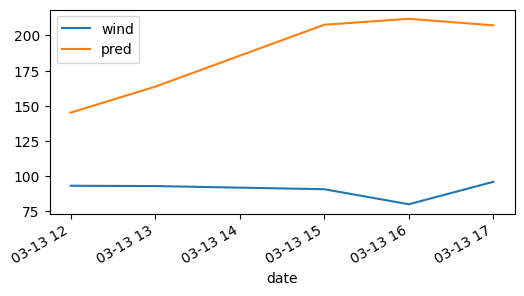

In [20]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.wind < 100]['wind'].plot(ax=ax)
predictions[df_test.wind < 100].plot(ax=ax)
ax.legend()
plt.show()

In [21]:
forecaster.fit(
    df_train['wind'],
    exog = df_train[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                     'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                     'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']])
forecaster.get_feature_importances()

feature  importance
0                       lag_1    0.986655
1                       lag_2    0.003864
2                       lag_3    0.002056
25      wind_speed_100m_wind1    0.001165
35      wind_speed_100m_wind3    0.000587
3                       lag_4    0.000544
30      wind_speed_100m_wind2    0.000444
24       wind_speed_10m_wind1    0.000418
4                       lag_5    0.000252
28       wind_gusts_10m_wind1    0.000247
29       wind_speed_10m_wind2    0.000227
34       wind_speed_10m_wind3    0.000219
38       wind_gusts_10m_wind3    0.000180
22                     lag_23    0.000180
5                       lag_6    0.000176
33       wind_gusts_10m_wind2    0.000171
23                     lag_24    0.000157
36   wind_direction_10m_wind3    0.000142
27  wind_direction_100m_wind1    0.000141
21                     lag_22    0.000140
31   wind_direction_10m_wind2    0.000135
6                       lag_7    0.000131
37  wind_direction_100m_wind3    0.000130
26   wind_direction_10m_wind1    0.000128
32  wind_direction_100m_wind2    0.000126
20                     lag_21    0.000112
10                     lag_11    0.000107
7                       lag_8    0.000106
8                       lag_9    0.000099
11                     lag_12    0.000098
12                     lag_13    0.000098
9                      lag_10    0.000098
15                     lag_16    0.000097
13                     lag_14    0.000096
16                     lag_17    0.000096
18                     lag_19    0.000096
17                     lag_18    0.000095
19                     lag_20    0.000094
14                     lag_15    0.000091

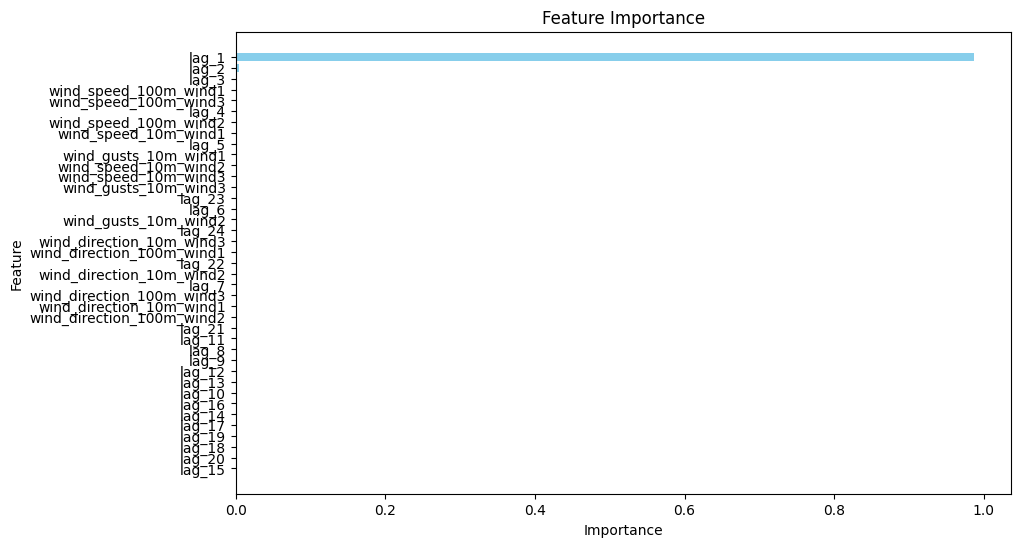

In [22]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 4.2.2. LightGBM

In [24]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, n_jobs = -1),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['wind'],
                          exog                  = df_model[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                                                            'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                                                            'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9740
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 39
[LightGBM] [Info] Start training from score 2518.594167


  0%|          | 0/50 [00:00<?, ?it/s]

In [25]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 495835.56449791195
RMSE: 704.1559234274124
MAE: 531.9717465754917
MAPE: 0.23126842994690372
Custom MAPE: 0.23126842994690372
Custom sMAPE: 0.11731372953507237


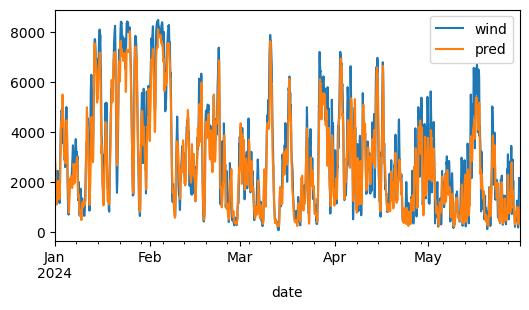

In [26]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['wind'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

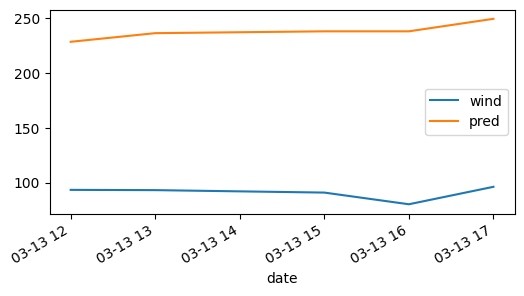

In [27]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.wind < 100]['wind'].plot(ax=ax)
predictions[df_test.wind < 100].plot(ax=ax)
ax.legend()
plt.show()

In [28]:
forecaster.fit(
    df_train['wind'],
    exog = df_train[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                     'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                     'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']])
forecaster.get_feature_importances()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9740
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 39
[LightGBM] [Info] Start training from score 2518.594167


feature  importance
0                       lag_1         538
1                       lag_2         308
30      wind_speed_100m_wind2         171
25      wind_speed_100m_wind1         168
35      wind_speed_100m_wind3         145
2                       lag_3         142
38       wind_gusts_10m_wind3          95
22                     lag_23          79
23                     lag_24          78
3                       lag_4          78
33       wind_gusts_10m_wind2          70
36   wind_direction_10m_wind3          69
34       wind_speed_10m_wind3          63
28       wind_gusts_10m_wind1          62
27  wind_direction_100m_wind1          60
4                       lag_5          57
21                     lag_22          56
26   wind_direction_10m_wind1          55
29       wind_speed_10m_wind2          52
37  wind_direction_100m_wind3          52
31   wind_direction_10m_wind2          49
24       wind_speed_10m_wind1          49
32  wind_direction_100m_wind2          44
5                       lag_6          39
6                       lag_7          37
8                       lag_9          36
7                       lag_8          35
13                     lag_14          32
16                     lag_17          31
15                     lag_16          30
20                     lag_21          28
18                     lag_19          28
10                     lag_11          28
12                     lag_13          27
9                      lag_10          25
11                     lag_12          23
17                     lag_18          22
19                     lag_20          20
14                     lag_15          19

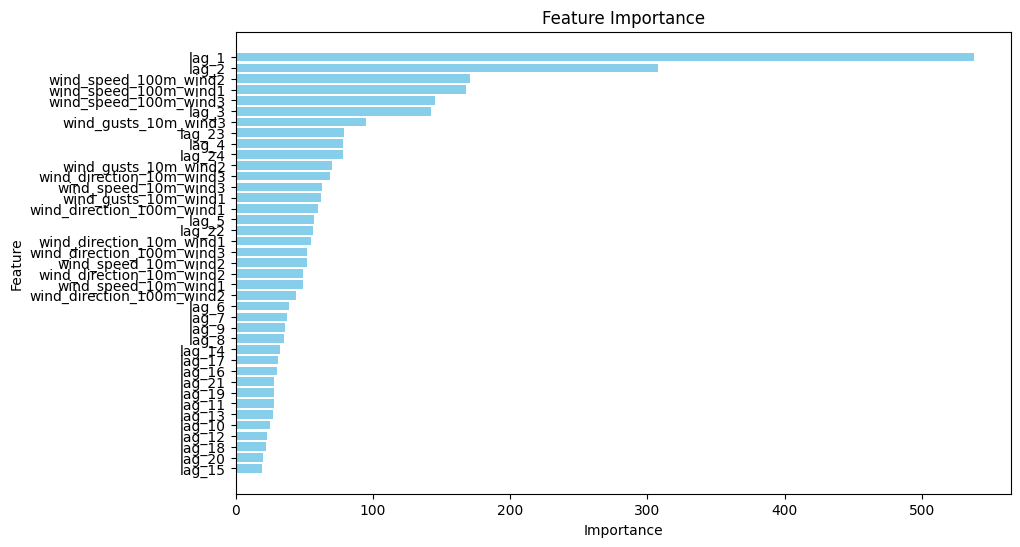

In [29]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 4.2.3. XGBoost

In [30]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123, n_jobs = -1),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['wind'],
                          exog                  = df_model[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                                                            'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                                                            'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

In [31]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 555019.4100124077
RMSE: 744.9962483210286
MAE: 561.5179486656262
MAPE: 0.2542945708601359
Custom MAPE: 0.2542945708601359
Custom sMAPE: 0.12556057173433552


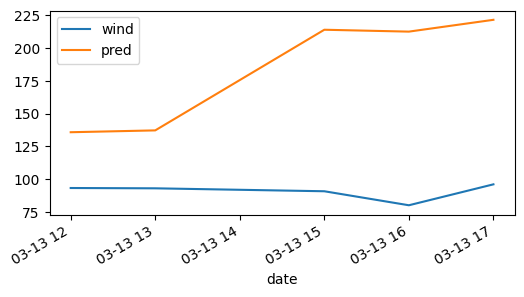

In [32]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.wind < 100]['wind'].plot(ax=ax)
predictions[df_test.wind < 100].plot(ax=ax)
ax.legend()
plt.show()

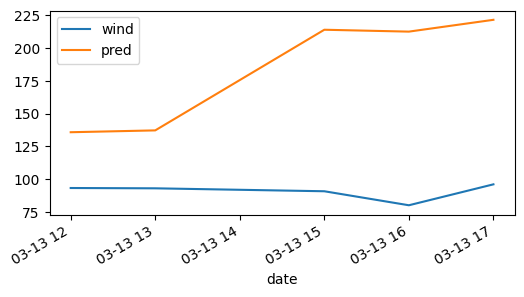

In [33]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.wind < 100]['wind'].plot(ax=ax)
predictions[df_test.wind < 100].plot(ax=ax)
ax.legend()
plt.show()

In [34]:
forecaster.fit(
    df_train['wind'],
    exog = df_train[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                     'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                     'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']])
forecaster.get_feature_importances()

feature  importance
0                       lag_1    0.954030
25      wind_speed_100m_wind1    0.005378
1                       lag_2    0.005337
2                       lag_3    0.005001
30      wind_speed_100m_wind2    0.003835
35      wind_speed_100m_wind3    0.003577
22                     lag_23    0.001075
36   wind_direction_10m_wind3    0.000960
21                     lag_22    0.000954
3                       lag_4    0.000883
29       wind_speed_10m_wind2    0.000883
38       wind_gusts_10m_wind3    0.000883
37  wind_direction_100m_wind3    0.000882
34       wind_speed_10m_wind3    0.000815
33       wind_gusts_10m_wind2    0.000806
4                       lag_5    0.000806
27  wind_direction_100m_wind1    0.000766
24       wind_speed_10m_wind1    0.000755
15                     lag_16    0.000744
28       wind_gusts_10m_wind1    0.000741
19                     lag_20    0.000729
6                       lag_7    0.000710
31   wind_direction_10m_wind2    0.000710
32  wind_direction_100m_wind2    0.000691
23                     lag_24    0.000647
16                     lag_17    0.000616
8                       lag_9    0.000595
20                     lag_21    0.000595
18                     lag_19    0.000550
12                     lag_13    0.000549
26   wind_direction_10m_wind1    0.000544
9                      lag_10    0.000540
14                     lag_15    0.000534
13                     lag_14    0.000531
7                       lag_8    0.000530
17                     lag_18    0.000494
5                       lag_6    0.000490
11                     lag_12    0.000434
10                     lag_11    0.000401

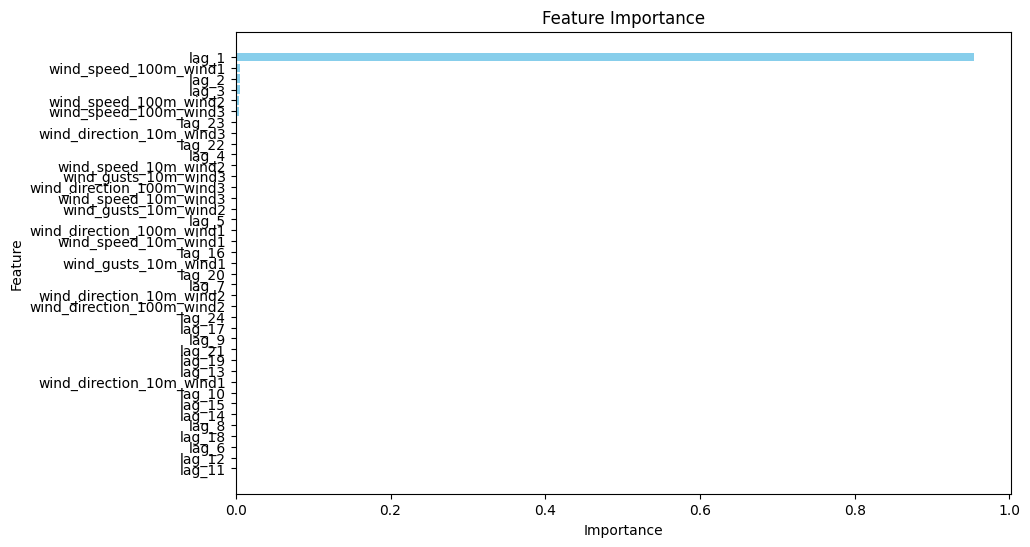

In [35]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 4.2.4. Optuna (LightGBM)

In [ ]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, n_jobs = -1),
                 lags      = 1 # Placeholder, the value will be overwritten
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'             : trial.suggest_categorical('lags', [1, 2, 3]),
        'num_leaves'       : trial.suggest_int('num_leaves', 2, 256),
        'max_depth'        : trial.suggest_int('max_depth', -1, 16),
        'learning_rate'    : trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        'n_estimators'     : trial.suggest_int('n_estimators', 50, 1500),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight' : trial.suggest_float('min_child_weight', 1e-3, 1e2, log=True),
        'subsample'        : trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq'   : trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha'        : trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda'       : trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }

    return search_space

results, best_trial = bayesian_search_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['wind'],
                          steps                 = 24*3,
                          exog                  = df_model[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                                                            'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                                                            'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']],
                          search_space          = search_space,
                          steps                 = 24*3+1,
                          metric                = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error'],
                          refit                 = False,
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          n_trials              = 100,
                          random_state          = 123,
                          return_best           = True,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {},
                          output_file           = google_drive_path + "results_total_recursive_optuna_lightGBM.txt"
                      )

In [37]:
# Print the best hyperparameters
print(best_trial.params)
print(best_trial.value)

{'lags': 2, 'num_leaves': 84, 'max_depth': 8, 'learning_rate': 0.009097938305291233, 'n_estimators': 989, 'min_child_samples': 34, 'min_child_weight': 0.0804821134687246, 'subsample': 0.18950167237932425, 'subsample_freq': 6, 'colsample_bytree': 0.3725844705156614, 'reg_alpha': 0.0009952481728406233, 'reg_lambda': 6.040076238725712e-05}
471.91953527866707


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
params = {'num_leaves': 84, 'max_depth': 8, 'learning_rate': 0.009097938305291233, 'n_estimators': 989, 'min_child_samples': 34,
          'min_child_weight': 0.0804821134687246, 'subsample': 0.18950167237932425, 'subsample_freq': 6, 'colsample_bytree': 0.3725844705156614,
          'reg_alpha': 0.0009952481728406233, 'reg_lambda': 6.040076238725712e-05}

# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, **params),
                 lags      = 2
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['wind'],
                          exog                  = df_model[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                                                            'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                                                            'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

In [43]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 381135.0539015295
RMSE: 617.3613641146727
MAE: 471.91953527866707
MAPE: 0.2109849152776022
Custom MAPE: 0.2109849152776022
Custom sMAPE: 0.10858496591933176


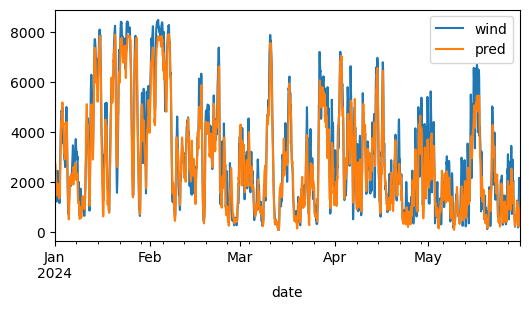

In [44]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['wind'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


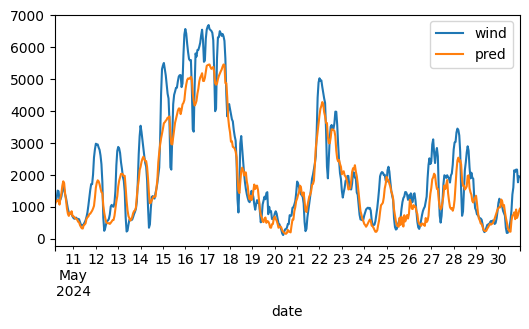

In [45]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['wind'][-500:].plot(ax=ax)
predictions[-500:].plot(ax=ax)
ax.legend()
plt.show();

In [46]:
forecaster.fit(
    df_train['wind'],
    exog = df_train[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                     'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                     'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


feature  importance
1                       lag_2        4053
13      wind_speed_100m_wind3        2737
3       wind_speed_100m_wind1        2680
0                       lag_1        2147
7        wind_speed_10m_wind2        2089
15  wind_direction_100m_wind3        2071
9    wind_direction_10m_wind2        2005
11       wind_gusts_10m_wind2        1938
5   wind_direction_100m_wind1        1651
16       wind_gusts_10m_wind3        1616
14   wind_direction_10m_wind3        1173
12       wind_speed_10m_wind3        1134
8       wind_speed_100m_wind2        1088
6        wind_gusts_10m_wind1         915
2        wind_speed_10m_wind1         740
4    wind_direction_10m_wind1         709
10  wind_direction_100m_wind2         618

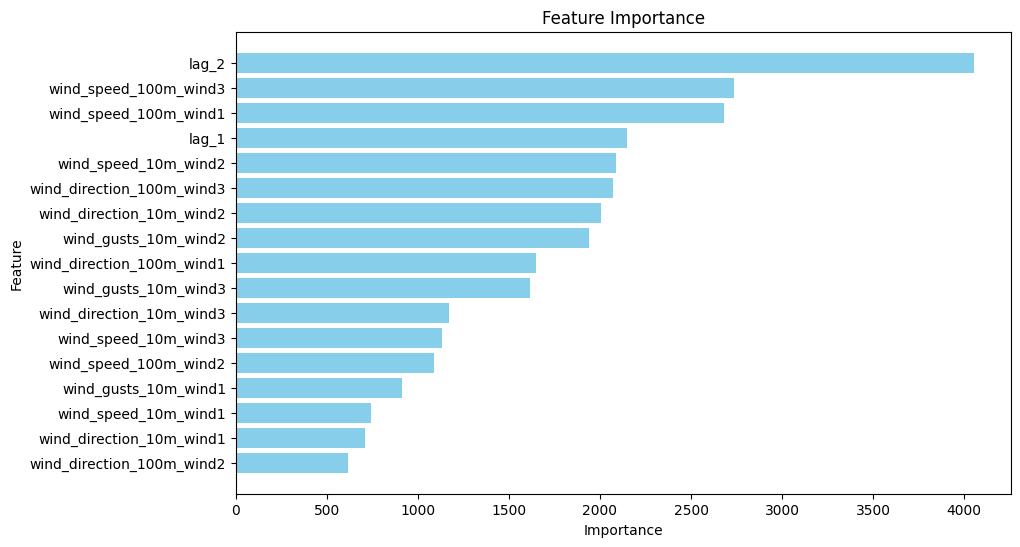

In [47]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

## 5.Total Generation Model

<Axes: >

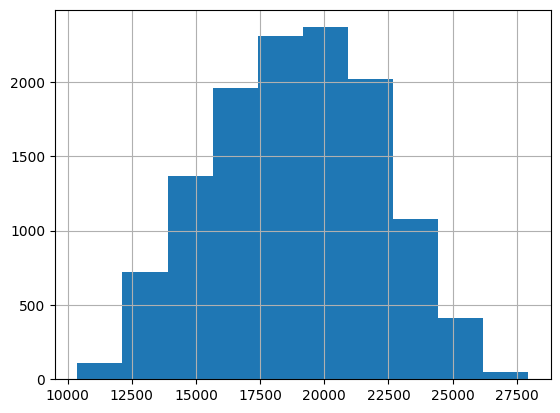

In [48]:
df_model['total'].hist()

### 5.1. Recursive multi-step forecasting (without weather inputs)

#### 5.1.1. Random Forests

In [150]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

In [149]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 381135.0539015295
RMSE: 617.3613641146727
MAE: 471.91953527866707
MAPE: 0.2109849152776022
Custom MAPE: 0.2109849152776022
Custom sMAPE: 0.10858496591933176


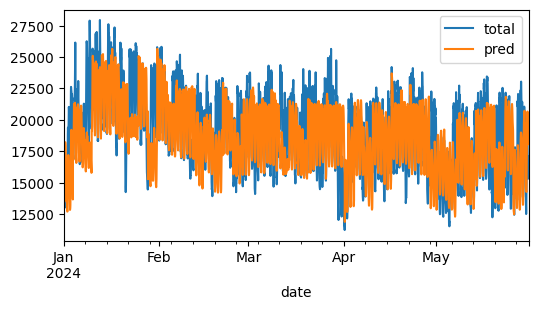

In [51]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [52]:
forecaster.fit(df_train['total'])
forecaster.get_feature_importances()

feature  importance
0    lag_1    0.936143
22  lag_23    0.010582
21  lag_22    0.007727
1    lag_2    0.006191
5    lag_6    0.004017
2    lag_3    0.003465
12  lag_13    0.003383
20  lag_21    0.003209
11  lag_12    0.003010
13  lag_14    0.002101
23  lag_24    0.002097
6    lag_7    0.001976
3    lag_4    0.001902
4    lag_5    0.001877
10  lag_11    0.001589
7    lag_8    0.001589
19  lag_20    0.001498
18  lag_19    0.001454
9   lag_10    0.001238
14  lag_15    0.001070
8    lag_9    0.001056
17  lag_18    0.001052
16  lag_17    0.000904
15  lag_16    0.000870

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


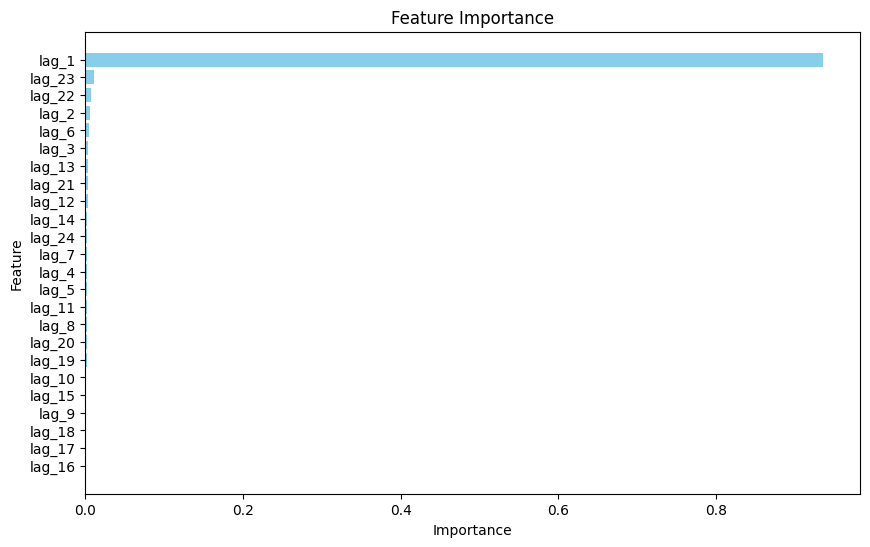

In [53]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 5.1.2. LightGBM

In [54]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 24
[LightGBM] [Info] Start training from score 18756.720898


  0%|          | 0/50 [00:00<?, ?it/s]

In [55]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 6322908.222541371
RMSE: 2514.5393658762578
MAE: 1888.2635143853518
MAPE: 0.09803165673470125
Custom MAPE: 0.09803165673470125
Custom sMAPE: 0.05049735481712075


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


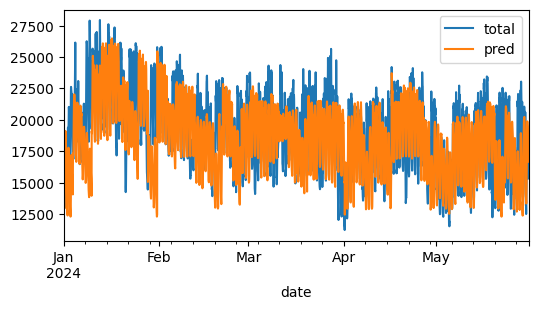

In [56]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [57]:
forecaster.fit(df_train['total'])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 24
[LightGBM] [Info] Start training from score 18756.720898


feature  importance
0    lag_1         515
1    lag_2         219
22  lag_23         195
23  lag_24         180
13  lag_14         127
10  lag_11         125
21  lag_22         120
12  lag_13         117
18  lag_19         112
5    lag_6         108
6    lag_7         108
9   lag_10         107
20  lag_21          98
7    lag_8          91
14  lag_15          90
11  lag_12          90
17  lag_18          88
3    lag_4          87
4    lag_5          77
2    lag_3          74
19  lag_20          72
8    lag_9          71
15  lag_16          67
16  lag_17          62

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


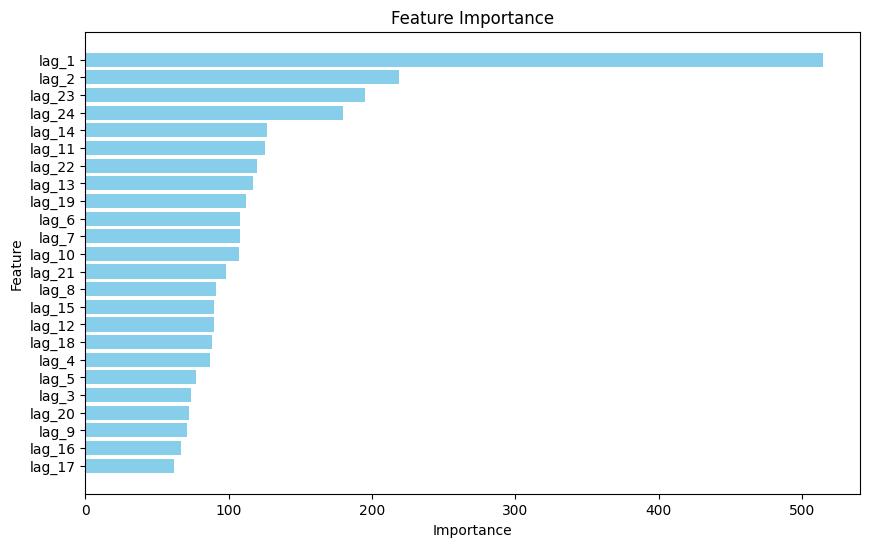

In [58]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 5.1.3. XGBoost

In [59]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

In [60]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 6604666.380128541
RMSE: 2569.954548261222
MAE: 1926.6022317248312
MAPE: 0.10049726890495746
Custom MAPE: 0.10049726890495746
Custom sMAPE: 0.05168036531868039


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


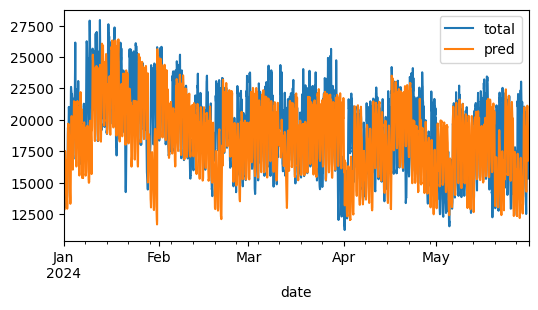

In [61]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [62]:
forecaster.fit(df_train['total'])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


feature  importance
0    lag_1    0.832215
22  lag_23    0.018903
21  lag_22    0.018414
1    lag_2    0.014781
20  lag_21    0.013591
5    lag_6    0.011949
12  lag_13    0.008963
19  lag_20    0.008797
10  lag_11    0.007332
13  lag_14    0.006862
4    lag_5    0.006837
11  lag_12    0.006244
2    lag_3    0.005609
23  lag_24    0.004657
18  lag_19    0.004461
7    lag_8    0.004423
6    lag_7    0.003976
17  lag_18    0.003829
3    lag_4    0.003393
9   lag_10    0.003335
14  lag_15    0.003215
8    lag_9    0.003197
15  lag_16    0.002513
16  lag_17    0.002504

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


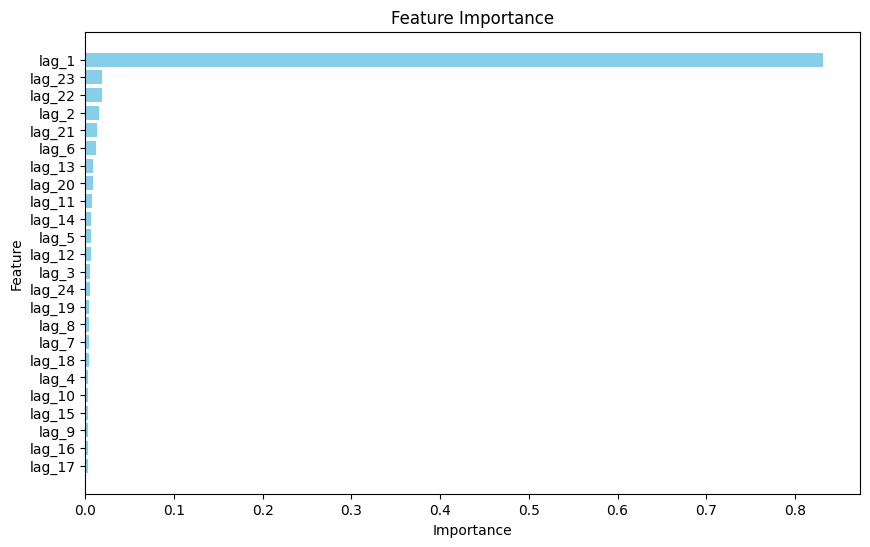

In [63]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

### 5.2. Recursive multi-step forecasting (with temp, dow, month, hour)

#### 5.2.1. Random Forests

In [151]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          exog                  = df_model[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

In [152]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 2790518.7797843087
RMSE: 1670.4845942972083
MAE: 1264.0530459646704
MAPE: 0.06668266517987904
Custom MAPE: 0.06668266517987904
Custom sMAPE: 0.0333208256218022


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


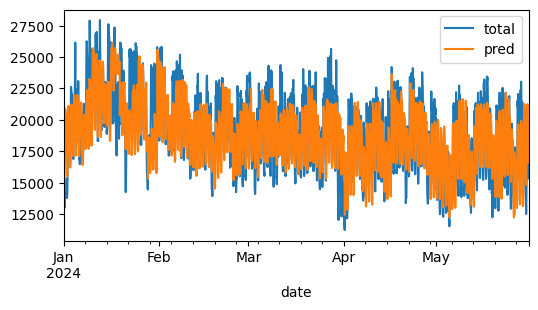

In [153]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [154]:
forecaster.fit(
    df_train['total'],
    exog = df_train[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


feature  importance
0                     lag_1    0.935757
30                    hhour    0.016298
22                   lag_23    0.007980
21                   lag_22    0.005830
1                     lag_2    0.004303
2                     lag_3    0.002925
28                      dow    0.002555
5                     lag_6    0.002119
20                   lag_21    0.001656
3                     lag_4    0.001560
12                   lag_13    0.001409
23                   lag_24    0.001387
4                     lag_5    0.001364
13                   lag_14    0.001126
11                   lag_12    0.001074
27  apparent_temperature_t3    0.001049
19                   lag_20    0.000971
6                     lag_7    0.000967
10                   lag_11    0.000932
18                   lag_19    0.000910
26  apparent_temperature_t2    0.000883
25  apparent_temperature_t1    0.000875
7                     lag_8    0.000778
14                   lag_15    0.000770
9                    lag_10    0.000728
24                is_day_t1    0.000724
15                   lag_16    0.000663
8                     lag_9    0.000656
17                   lag_18    0.000609
29                   mmonth    0.000575
16                   lag_17    0.000568

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


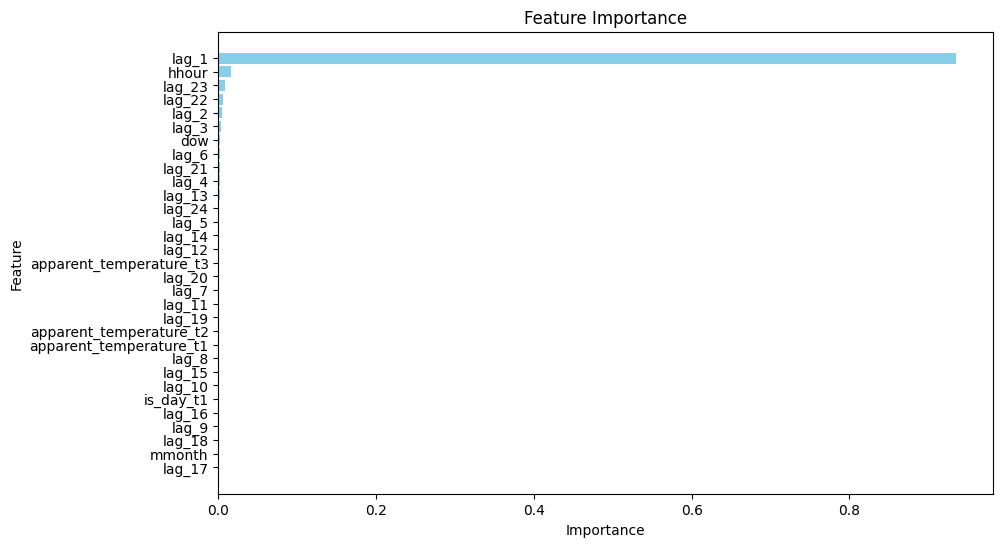

In [155]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 5.2.2. LightGBM

In [156]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          exog                  = df_model[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6931
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 31
[LightGBM] [Info] Start training from score 18756.720898


  0%|          | 0/50 [00:00<?, ?it/s]

In [157]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1689620.6892226597
RMSE: 1299.8541030525926
MAE: 992.3560675405662
MAPE: 0.05285851279865753
Custom MAPE: 0.05285851279865753
Custom sMAPE: 0.026228086594859142


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


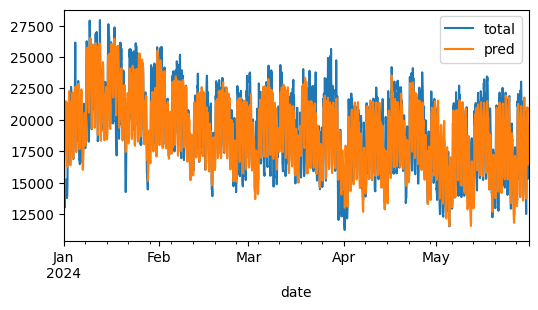

In [158]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [159]:
forecaster.fit(
    df_train['total'],
    exog = df_train[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6931
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 31
[LightGBM] [Info] Start training from score 18756.720898


feature  importance
30                    hhour         468
0                     lag_1         392
1                     lag_2         155
28                      dow         154
22                   lag_23         138
26  apparent_temperature_t2         127
27  apparent_temperature_t3          88
25  apparent_temperature_t1          86
3                     lag_4          86
2                     lag_3          81
12                   lag_13          77
21                   lag_22          75
4                     lag_5          75
5                     lag_6          75
13                   lag_14          67
23                   lag_24          65
6                     lag_7          64
15                   lag_16          62
14                   lag_15          60
10                   lag_11          60
9                    lag_10          58
7                     lag_8          57
18                   lag_19          55
20                   lag_21          55
19                   lag_20          53
24                is_day_t1          49
8                     lag_9          48
16                   lag_17          47
11                   lag_12          46
29                   mmonth          42
17                   lag_18          35

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


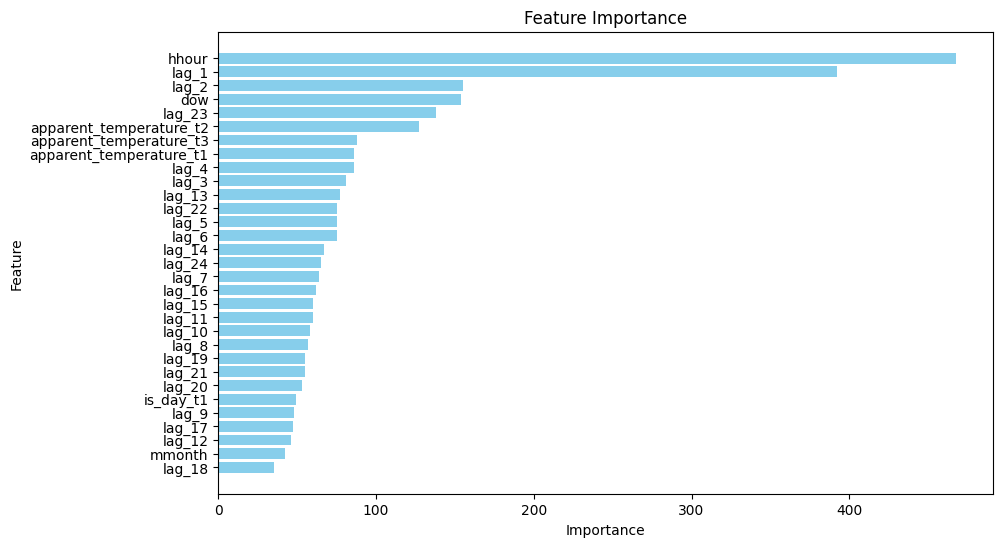

In [160]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 5.2.3. XGBoost

In [161]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          exog                  = df_model[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

In [162]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 2183788.12110516
RMSE: 1477.7645689030307
MAE: 1115.9370224218535
MAPE: 0.059583232051238215
Custom MAPE: 0.059583232051238215
Custom sMAPE: 0.029771583438480412


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


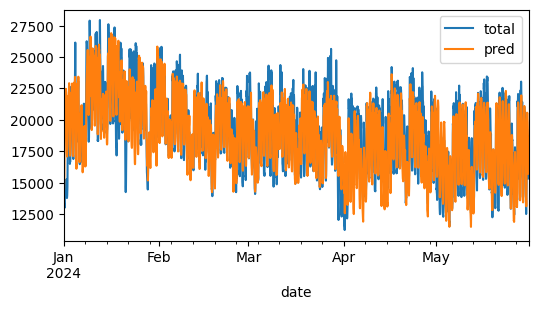

In [163]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [164]:
forecaster.fit(
    df_train['total'],
    exog = df_train[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


feature  importance
0                     lag_1    0.818624
30                    hhour    0.039170
21                   lag_22    0.022434
22                   lag_23    0.020451
28                      dow    0.012419
24                is_day_t1    0.010560
1                     lag_2    0.009548
5                     lag_6    0.009507
19                   lag_20    0.007558
12                   lag_13    0.005214
13                   lag_14    0.003684
18                   lag_19    0.003536
2                     lag_3    0.003480
4                     lag_5    0.002582
27  apparent_temperature_t3    0.002428
23                   lag_24    0.002357
29                   mmonth    0.002211
10                   lag_11    0.002154
26  apparent_temperature_t2    0.001904
6                     lag_7    0.001874
9                    lag_10    0.001860
14                   lag_15    0.001829
20                   lag_21    0.001828
25  apparent_temperature_t1    0.001796
16                   lag_17    0.001733
11                   lag_12    0.001700
3                     lag_4    0.001674
17                   lag_18    0.001581
15                   lag_16    0.001575
7                     lag_8    0.001427
8                     lag_9    0.001301

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


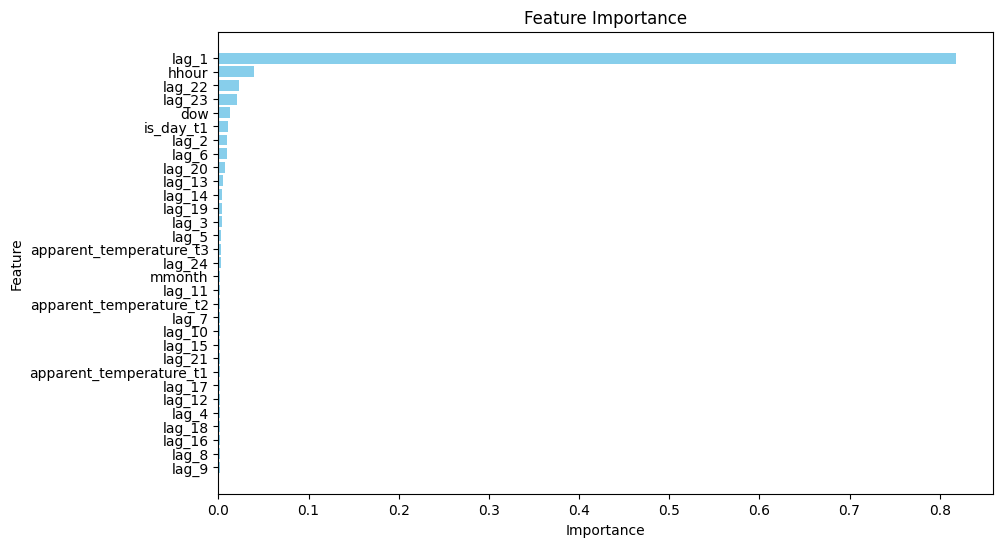

In [165]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 5.2.4. Optuna (LightGBM)

In [166]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1),
                 lags      = 24 # Placeholder, the value will be overwritten
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'             : trial.suggest_categorical('lags', [1, 3, 6, 12, 24]),
        'num_leaves'       : trial.suggest_int('num_leaves', 2, 256),
        'max_depth'        : trial.suggest_int('max_depth', -1, 16),
        'learning_rate'    : trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        'n_estimators'     : trial.suggest_int('n_estimators', 50, 1500),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight' : trial.suggest_float('min_child_weight', 1e-3, 1e2, log=True),
        'subsample'        : trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq'   : trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha'        : trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda'       : trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }

    return search_space

results, best_trial = bayesian_search_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          exog                  = df_model[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          search_space          = search_space,
                          steps                 = 24*3+1,
                          metric                = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error'],
                          refit                 = False,
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          n_trials              = 100,
                          random_state          = 123,
                          return_best           = True,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {},
                          output_file           = google_drive_path + "results_total_recursive_optuna_lightGBM.txt"
                      )

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-31 08:11:32,599] Trial 0 finished with value: 1072.521413061741 and parameters: {'lags': 24, 'num_leaves': 109, 'max_depth': 16, 'learning_rate': 0.05486797781181634, 'n_estimators': 747, 'min_child_samples': 42, 'min_child_weight': 0.051986440302397775, 'subsample': 0.7561447366456374, 'subsample_freq': 4, 'colsample_bytree': 0.15371010694861154, 'reg_alpha': 1.528811858152725e-05, 'reg_lambda': 0.008016102206099943}. Best is trial 0 with value: 1072.521413061741.
[I 2024-07-31 08:11:42,657] Trial 1 finished with value: 1081.6337258018823 and parameters: {'lags': 24, 'num_leaves': 218, 'max_depth': 12, 'learning_rate': 0.02780315255778501, 'n_estimators': 1098, 'min_child_samples': 36, 'min_child_weight': 0.06440851380101245, 'subsample': 0.30543690779106003, 'subsample_freq': 3, 'colsample_bytree': 0.667878511469039, 'reg_alpha': 5.455562299744123e-08, 'reg_lambda': 2.9485560066017848e-05}. Best is trial 0 with value: 1072.521413061741.
[I 2024-07-31 08:11:50,879] Trial 2 

In [167]:
# Print the best hyperparameters
print(best_trial.params)
print(best_trial.value)

{'lags': 1, 'num_leaves': 44, 'max_depth': 11, 'learning_rate': 0.006857266832854931, 'n_estimators': 721, 'min_child_samples': 13, 'min_child_weight': 0.03314197175238346, 'subsample': 0.6845684084457395, 'subsample_freq': 1, 'colsample_bytree': 0.9999577589484245, 'reg_alpha': 0.00037359713404698947, 'reg_lambda': 5.217052797174865e-06}
995.1409925919507


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [170]:
params = { 'num_leaves': 44, 'max_depth': 11, 'learning_rate': 0.006857266832854931, 'n_estimators': 721, 'min_child_samples': 13,
'min_child_weight': 0.03314197175238346, 'subsample': 0.6845684084457395, 'subsample_freq': 1, 'colsample_bytree': 0.9999577589484245,
           'reg_alpha': 0.00037359713404698947, 'reg_lambda': 5.217052797174865e-06}

# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, **params),
                 lags      = 1
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          exog                  = df_model[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

In [171]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1731463.7213595088
RMSE: 1315.8509495225926
MAE: 995.1409925919507
MAPE: 0.05333233503027261
Custom MAPE: 0.05333233503027261
Custom sMAPE: 0.026301594666925717


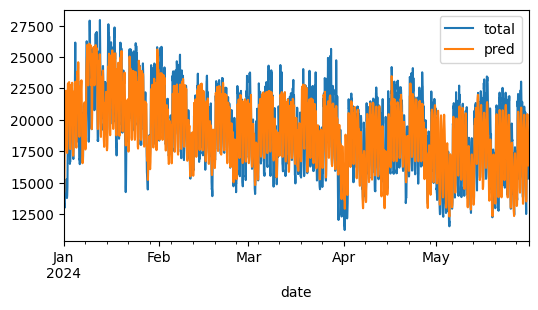

In [172]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [173]:
forecaster.fit(
    df_train['total'],
    exog = df_train[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


feature  importance
7                    hhour       13763
0                    lag_1        6643
5                      dow        2369
3  apparent_temperature_t2        1940
4  apparent_temperature_t3        1756
6                   mmonth        1743
2  apparent_temperature_t1        1577
1                is_day_t1        1212

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


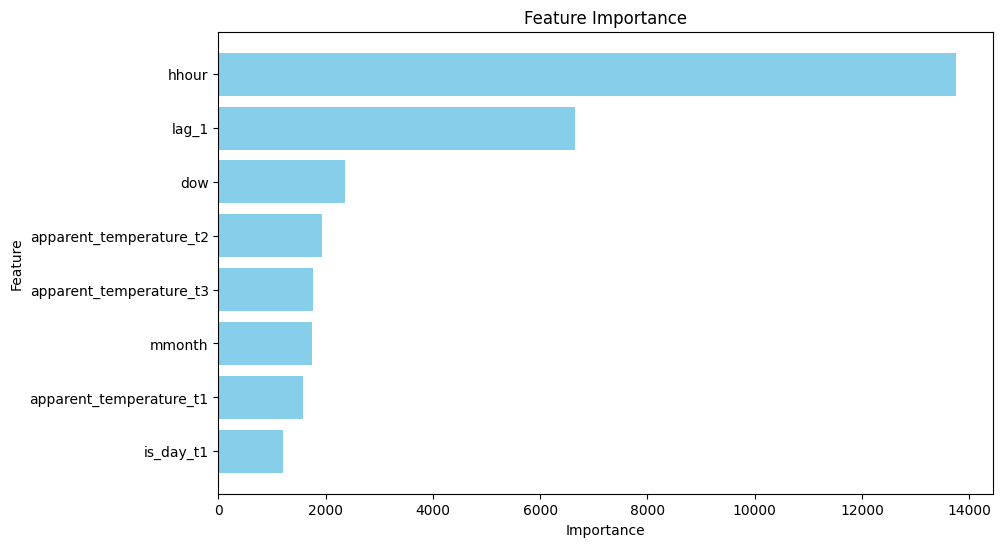

In [174]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

## 6.PV Generation Model

<Axes: >

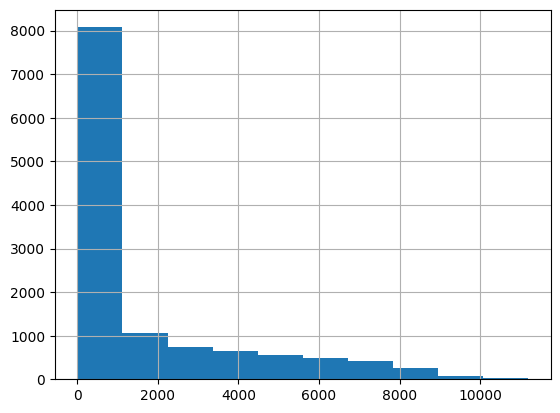

In [89]:
df_model['pv'].hist()

### 6.1. Recursive multi-step forecasting (without weather inputs)

#### 6.1.1. Random Forests

In [90]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

In [91]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 962205.6691526094
RMSE: 980.9208271581399
MAE: 475.52619017940935
MAPE: 740223331931676.4
Custom MAPE: 0.2725606889019738
Custom sMAPE: 0.13317704767562272


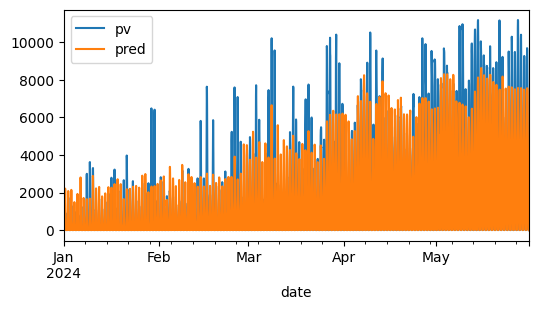

In [92]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


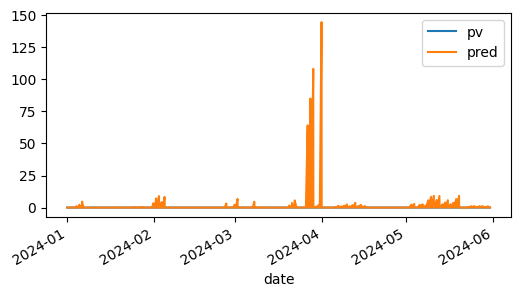

In [93]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

#### 6.1.2. LightGBM

In [94]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 24
[LightGBM] [Info] Start training from score 1512.660084


  0%|          | 0/50 [00:00<?, ?it/s]

In [95]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 2018118.961206672
RMSE: 1420.6051390892094
MAE: 666.2649815888547
MAPE: 3147985493261175.5
Custom MAPE: 0.765956956559503
Custom sMAPE: 0.5622024819787023


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


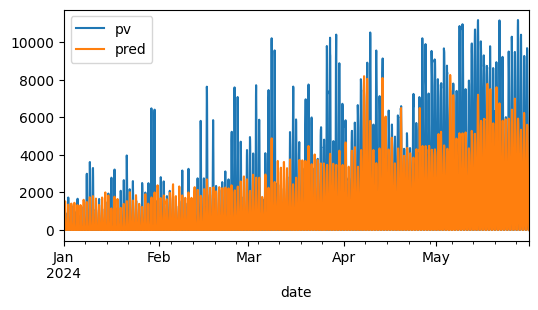

In [96]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


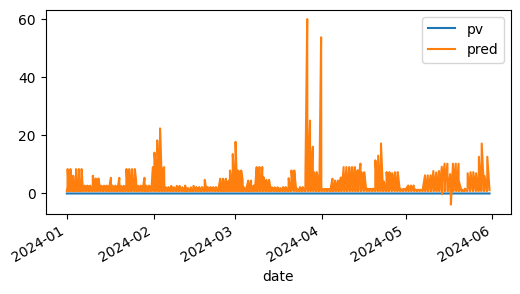

In [97]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

#### 6.1.3. XGBoost

In [101]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

In [102]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1626159.0087307908
RMSE: 1275.2093979934398
MAE: 592.9492927519011
MAPE: 1.2449098640053496e+16
Custom MAPE: 1.1953446540632255
Custom sMAPE: 0.5623648379113515


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


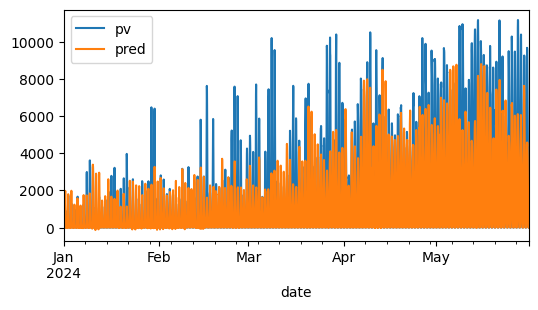

In [103]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


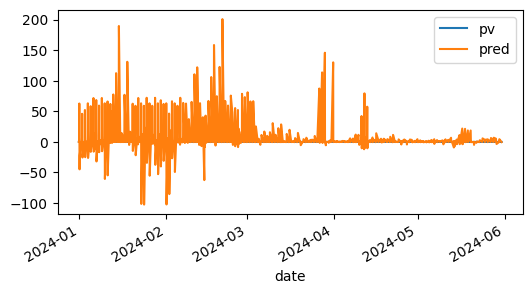

In [104]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

### 6.2. Recursive multi-step forecasting (with temp, month, hour)

#### 6.2.1. Random Forests

In [105]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/50 [00:00<?, ?it/s]

In [106]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 733742.1828344088
RMSE: 856.5875219931754
MAE: 408.44052906155116
MAPE: 496566037203756.9
Custom MAPE: 0.17506436268671433
Custom sMAPE: 0.10776165420377376


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


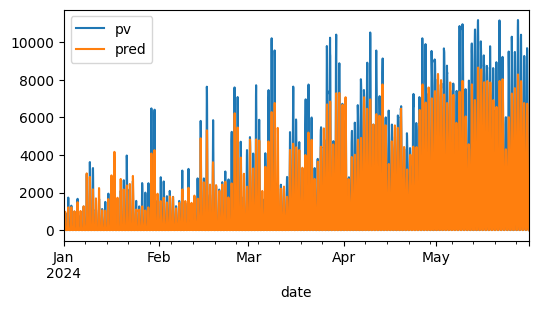

In [107]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


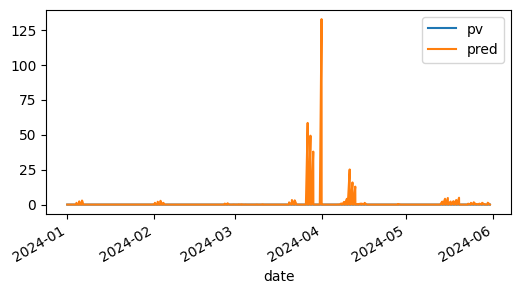

In [108]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

In [109]:
forecaster.fit(
    df_train['pv'],
    exog = df_train[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


feature  importance
0                                 lag_1    0.508953
34               shortwave_radiation_t1    0.280050
28             terrestrial_radiation_t2    0.068360
38             terrestrial_radiation_t1    0.065445
48             terrestrial_radiation_t3    0.019559
20                               lag_21    0.008611
19                               lag_20    0.007794
23                               lag_24    0.005757
18                               lag_19    0.005281
21                               lag_22    0.003287
17                               lag_18    0.002999
33     terrestrial_radiation_instant_t2    0.002567
39       shortwave_radiation_instant_t1    0.002078
24               shortwave_radiation_t2    0.001599
3                                 lag_4    0.001313
16                               lag_17    0.001158
2                                 lag_3    0.001109
4                                 lag_5    0.001077
29       shortwave_radiation_instant_t2    0.000981
5                                 lag_6    0.000953
22                               lag_23    0.000887
36                 diffuse_radiation_t1    0.000794
40          direct_radiation_instant_t1    0.000651
15                               lag_16    0.000650
43     terrestrial_radiation_instant_t1    0.000597
25                  direct_radiation_t2    0.000539
1                                 lag_2    0.000534
49       shortwave_radiation_instant_t3    0.000528
42  direct_normal_irradiance_instant_t1    0.000513
37          direct_normal_irradiance_t1    0.000481
6                                 lag_7    0.000466
41         diffuse_radiation_instant_t1    0.000412
30          direct_radiation_instant_t2    0.000362
46                 diffuse_radiation_t3    0.000331
26                 diffuse_radiation_t2    0.000300
32  direct_normal_irradiance_instant_t2    0.000288
47          direct_normal_irradiance_t3    0.000286
27          direct_normal_irradiance_t2    0.000284
35                  direct_radiation_t1    0.000267
31         diffuse_radiation_instant_t2    0.000249
14                               lag_15    0.000243
7                                 lag_8    0.000225
50          direct_radiation_instant_t3    0.000194
8                                 lag_9    0.000176
44               shortwave_radiation_t3    0.000174
45                  direct_radiation_t3    0.000129
9                                lag_10    0.000120
13                               lag_14    0.000111
10                               lag_11    0.000107
12                               lag_13    0.000085
11                               lag_12    0.000084

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


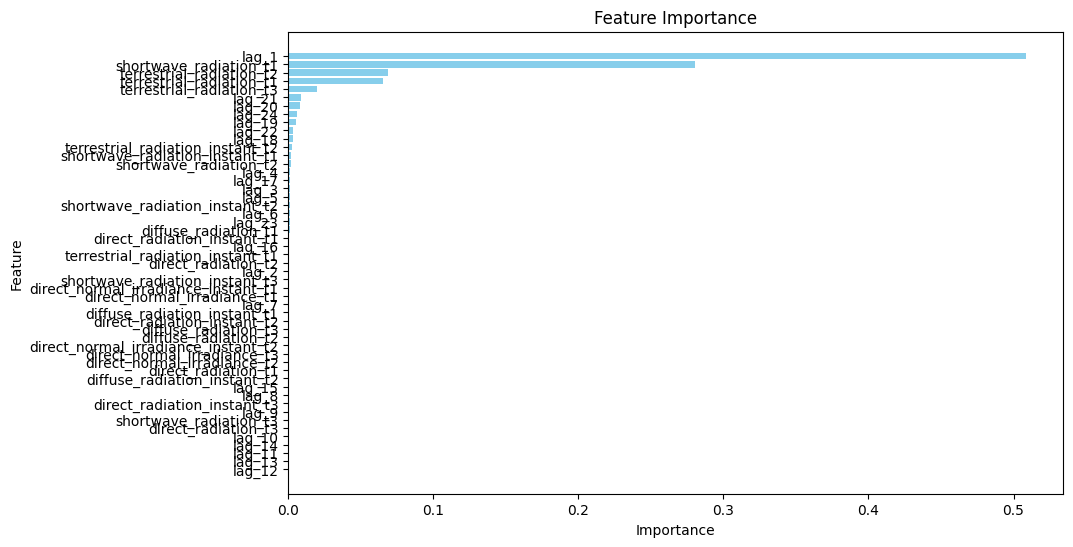

In [110]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 6.2.2. LightGBM

In [111]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13005
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 51
[LightGBM] [Info] Start training from score 1512.660084


  0%|          | 0/50 [00:00<?, ?it/s]

In [112]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 818781.5216786456
RMSE: 904.8654715915762
MAE: 434.6297239360872
MAPE: 3739290819681237.0
Custom MAPE: 0.6423207351446322
Custom sMAPE: 0.5501804984663683


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


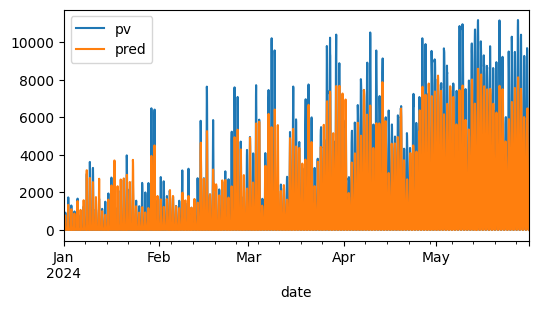

In [113]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


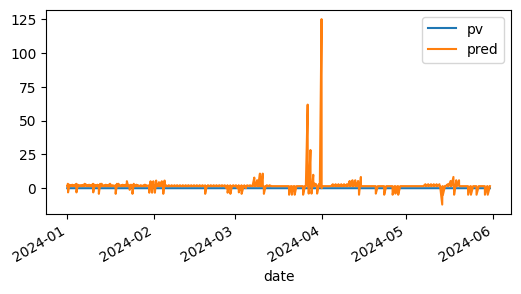

In [114]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

In [115]:
forecaster.fit(
    df_train['pv'],
    exog = df_train[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13005
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 51
[LightGBM] [Info] Start training from score 1512.660084


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


feature  importance
0                                 lag_1         615
2                                 lag_3         133
23                               lag_24         127
46                 diffuse_radiation_t3         101
1                                 lag_2          99
3                                 lag_4          90
26                 diffuse_radiation_t2          86
34               shortwave_radiation_t1          86
36                 diffuse_radiation_t1          73
24               shortwave_radiation_t2          73
21                               lag_22          64
37          direct_normal_irradiance_t1          61
4                                 lag_5          61
20                               lag_21          60
29       shortwave_radiation_instant_t2          59
47          direct_normal_irradiance_t3          59
28             terrestrial_radiation_t2          57
19                               lag_20          55
27          direct_normal_irradiance_t2          53
41         diffuse_radiation_instant_t1          52
49       shortwave_radiation_instant_t3          52
18                               lag_19          51
39       shortwave_radiation_instant_t1          51
5                                 lag_6          50
48             terrestrial_radiation_t3          49
33     terrestrial_radiation_instant_t2          46
35                  direct_radiation_t1          42
22                               lag_23          40
31         diffuse_radiation_instant_t2          39
40          direct_radiation_instant_t1          37
16                               lag_17          36
50          direct_radiation_instant_t3          33
14                               lag_15          32
44               shortwave_radiation_t3          32
25                  direct_radiation_t2          31
30          direct_radiation_instant_t2          31
15                               lag_16          29
6                                 lag_7          26
42  direct_normal_irradiance_instant_t1          25
12                               lag_13          24
7                                 lag_8          23
32  direct_normal_irradiance_instant_t2          23
17                               lag_18          21
43     terrestrial_radiation_instant_t1          20
8                                 lag_9          17
45                  direct_radiation_t3          16
9                                lag_10          16
38             terrestrial_radiation_t1          14
13                               lag_14          12
10                               lag_11          10
11                               lag_12           8

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


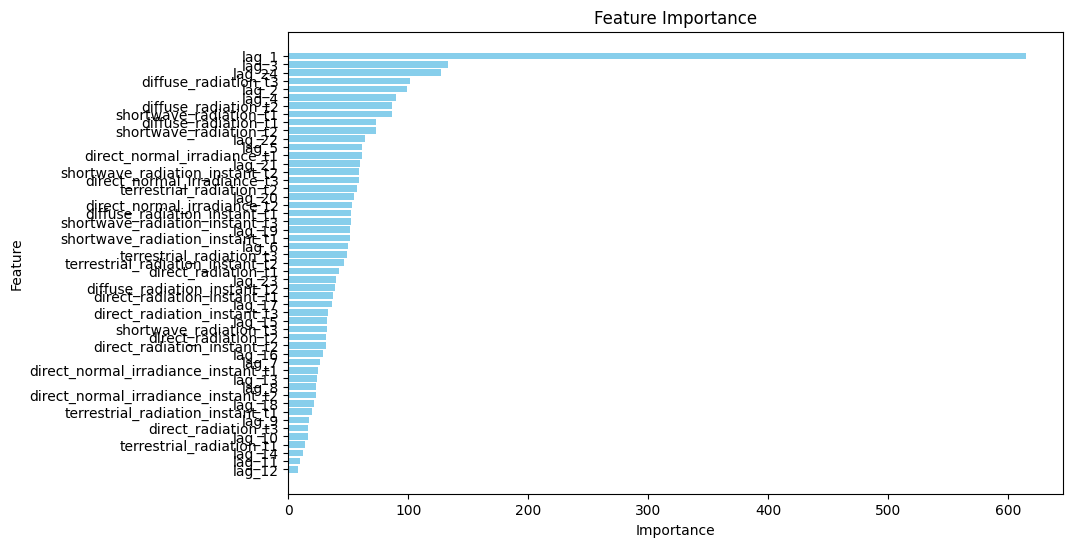

In [116]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 6.2.3. XGBoost

In [117]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

In [118]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 861740.5708042559
RMSE: 928.2998280750977
MAE: 446.3630787496353
MAPE: 1472414021161304.8
Custom MAPE: 0.6166031033562109
Custom sMAPE: 0.5299277876746711


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


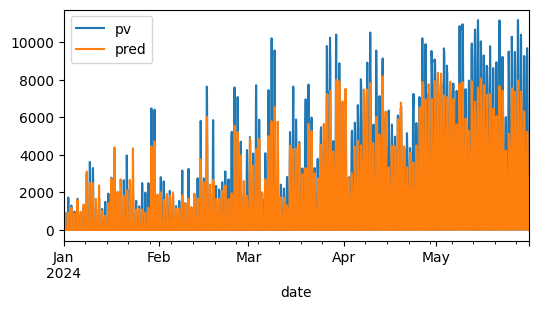

In [119]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


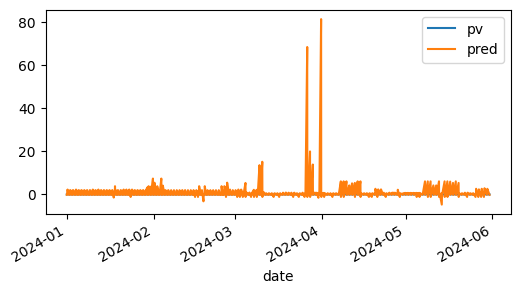

In [120]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

#### 6.2.4. Optuna (LightGBM)

In [121]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1),
                 lags      = 24 # Placeholder, the value will be overwritten
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'             : trial.suggest_categorical('lags', [1, 3, 6, 12, 24]),
        'num_leaves'       : trial.suggest_int('num_leaves', 2, 256),
        'max_depth'        : trial.suggest_int('max_depth', -1, 16),
        'learning_rate'    : trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        'n_estimators'     : trial.suggest_int('n_estimators', 50, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight' : trial.suggest_float('min_child_weight', 1e-3, 1e2, log=True),
        'subsample'        : trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq'   : trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha'        : trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda'       : trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }

    return search_space

results, best_trial = bayesian_search_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          search_space          = search_space,
                          steps                 = 24*3+1,
                          metric                = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error'],
                          refit                 = False,
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          n_trials              = 100,
                          random_state          = 123,
                          return_best           = True,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {},
                          output_file           = google_drive_path + "results_pv_recursive_optuna_lightGBM.txt"
                      )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-31 07:53:52,857] Trial 0 finished with value: 407.0261409837713 and parameters: {'lags': 24, 'num_leaves': 109, 'max_depth': 16, 'learning_rate': 0.05486797781181634, 'n_estimators': 507, 'min_child_samples': 42, 'min_child_weight': 0.051986440302397775, 'subsample': 0.7561447366456374, 'subsample_freq': 4, 'colsample_bytree': 0.15371010694861154, 'reg_alpha': 1.528811858152725e-05, 'reg_lambda': 0.008016102206099943}. Best is trial 0 with value: 407.0261409837713.
[I 2024-07-31 07:54:00,537] Trial 1 finished with value: 420.95277170446934 and parameters: {'lags': 24, 'num_leaves': 218, 'max_depth': 12, 'learning_rate': 0.02780315255778501, 'n_estimators': 737, 'min_child_samples': 36, 'min_child_weight': 0.06440851380101245, 'subsample': 0.30543690779106003, 'subsample_freq': 3, 'colsample_bytree': 0.667878511469039, 'reg_alpha': 5.455562299744123e-08, 'reg_lambda': 2.9485560066017848e-05}. Best is trial 0 with value: 407.0261409837713.
[I 2024-07-31 07:54:06,364] Trial 2 f

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [122]:
# Print the best hyperparameters
print(best_trial.params)
print(best_trial.value)

{'lags': 3, 'num_leaves': 82, 'max_depth': 9, 'learning_rate': 0.018413051014594402, 'n_estimators': 385, 'min_child_samples': 38, 'min_child_weight': 1.3142102071351776, 'subsample': 0.9502289556651793, 'subsample_freq': 3, 'colsample_bytree': 0.2698590364747545, 'reg_alpha': 7.56182988136327e-08, 'reg_lambda': 8.031715375361947e-06}
389.52973797564835


In [183]:
params = {'num_leaves': 82, 'max_depth': 9, 'learning_rate': 0.018413051014594402, 'n_estimators': 385, 'min_child_samples': 38,
          'min_child_weight': 1.3142102071351776, 'subsample': 0.9502289556651793, 'subsample_freq': 3, 'colsample_bytree': 0.2698590364747545,
          'reg_alpha': 7.56182988136327e-08, 'reg_lambda': 8.031715375361947e-06}


# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, **params),
                 lags      = 3
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

In [184]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 647536.4818715804
RMSE: 804.696515384266
MAE: 389.52973797564835
MAPE: 3919951789951364.5
Custom MAPE: 0.5876216052276847
Custom sMAPE: 0.5206606840592327


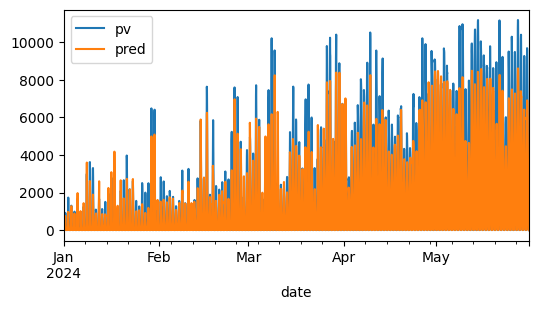

In [127]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


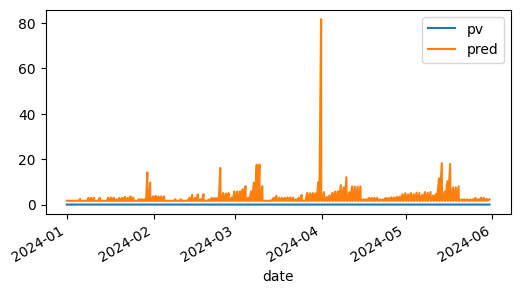

In [128]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

In [129]:
def correct_pv_predictions(pred_pv, shortwave_radiation):
  return 0 if shortwave_radiation == 0 or pred_pv < 0 else pred_pv

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
predictions_pv_corrected = \
pd.DataFrame({'predictions_pv': predictions.pred, 'shortwave_radiation_t1': df_test.shortwave_radiation_t1})

predictions_pv_corrected['predictions_pv'] = \
predictions_pv_corrected.apply(lambda row: correct_pv_predictions(row.predictions_pv, row.shortwave_radiation_t1), axis = 1)

predictions_pv_corrected = predictions_pv_corrected['predictions_pv']
predictions_pv_corrected

In [131]:
# Backtest error
# ==============================================================================
print("MSE: " + str(mean_squared_error(df_test.pv, predictions_pv_corrected)))
print("RMSE: " + str(mean_squared_error(df_test.pv, predictions_pv_corrected)**0.5))
print("MAE: " +  str(mean_absolute_error(df_test.pv, predictions_pv_corrected)))
print("Custom MAPE: " +  str(custom_mape(df_test.pv, predictions_pv_corrected)))
print("Custom sMAPE: " +  str(custom_smape(df_test.pv, predictions_pv_corrected)))

MSE: 647604.0829683035
RMSE: 804.7385183824019
MAE: 389.4356111352659
Custom MAPE: 0.17204666318331316
Custom sMAPE: 0.11834459138363114


In [132]:
forecaster.fit(
    df_train['pv'],
    exog = df_train[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


feature  importance
2                                 lag_3        3070
0                                 lag_1        1902
10         diffuse_radiation_instant_t2        1438
18       shortwave_radiation_instant_t1        1297
27             terrestrial_radiation_t3        1068
6           direct_normal_irradiance_t2         946
22     terrestrial_radiation_instant_t1         939
12     terrestrial_radiation_instant_t2         932
14                  direct_radiation_t1         901
1                                 lag_2         844
26          direct_normal_irradiance_t3         832
28       shortwave_radiation_instant_t3         711
4                   direct_radiation_t2         704
20         diffuse_radiation_instant_t1         690
29          direct_radiation_instant_t3         639
16          direct_normal_irradiance_t1         610
8        shortwave_radiation_instant_t2         601
7              terrestrial_radiation_t2         587
24                  direct_radiation_t3         576
3                shortwave_radiation_t2         532
25                 diffuse_radiation_t3         530
13               shortwave_radiation_t1         462
17             terrestrial_radiation_t1         461
5                  diffuse_radiation_t2         438
15                 diffuse_radiation_t1         416
11  direct_normal_irradiance_instant_t2         369
23               shortwave_radiation_t3         366
21  direct_normal_irradiance_instant_t1         298
9           direct_radiation_instant_t2         286
19          direct_radiation_instant_t1         249

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


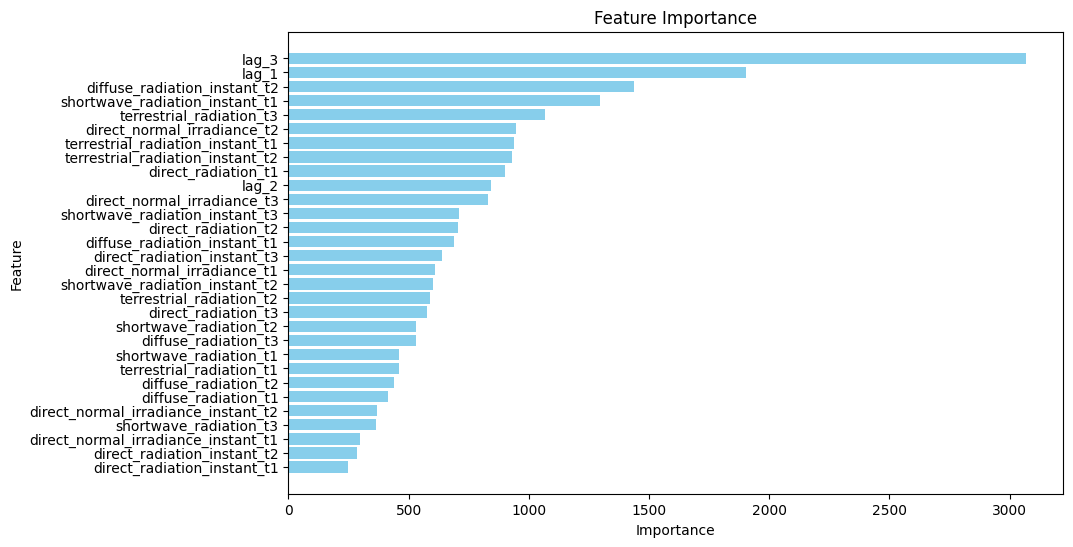

In [133]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 6.2.5. Optuna (Random Forests)

In [192]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24 # Placeholder, the value will be overwritten
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'             : trial.suggest_categorical('lags', [1, 3, 6, 12, 24]),
        'n_estimators'     : trial.suggest_int('n_estimators', 100, 1000),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 20),
        "max_depth"        : trial.suggest_int("max_depth", 2, 15),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 50),
        'max_features'     : trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_samples'      : trial.suggest_float('max_samples', 0.1, 1.0, step=0.1)
    }

    return search_space

results, best_trial = bayesian_search_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          search_space          = search_space,
                          steps                 = 24*3+1,
                          metric                = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error'],
                          refit                 = False,
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          n_trials              = 50,
                          random_state          = 123,
                          return_best           = True,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {},
                          output_file           = google_drive_path + "results_pv_recursive_optuna_lightGBM.txt"
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-07-31 08:32:48,415] Trial 0 finished with value: 386.72393988582866 and parameters: {'lags': 24, 'n_estimators': 481, 'min_samples_leaf': 20, 'max_depth': 11, 'min_samples_split': 25, 'max_features': 'sqrt', 'max_samples': 0.8}. Best is trial 0 with value: 386.72393988582866.
[I 2024-07-31 08:33:40,946] Trial 1 finished with value: 394.79671813577085 and parameters: {'lags': 12, 'n_estimators': 258, 'min_samples_leaf': 11, 'max_depth': 9, 'min_samples_split': 33, 'max_features': 'sqrt', 'max_samples': 0.7000000000000001}. Best is trial 0 with value: 386.72393988582866.
[I 2024-07-31 08:35:48,221] Trial 2 finished with value: 391.4913293607592 and parameters: {'lags': 1, 'n_estimators': 668, 'min_samples_leaf': 2, 'max_depth': 8, 'min_samples_split': 23, 'max_features': 'sqrt', 'max_samples': 0.4}. Best is trial 0 with value: 386.72393988582866.
[I 2024-07-31 08:36:30,405] Trial 3 finished with value: 391.84161582473615 and parameters: {'lags': 6, 'n_estimators': 204, 'min_sampl

In [193]:
# Print the best hyperparameters
print(best_trial.params)
print(best_trial.value)

{'lags': 24, 'n_estimators': 664, 'min_samples_leaf': 1, 'max_depth': 12, 'min_samples_split': 28, 'max_features': 'log2', 'max_samples': 0.7000000000000001}
384.65867674969223


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
params = {'n_estimators': 272, 'min_samples_leaf': 6, 'max_depth': 13, 'min_samples_split': 44, 'max_features': 'log2', 'max_samples': 0.5}

# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123, **params),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 677470.5681915986
RMSE: 823.086002913182
MAE: 387.17123612314856
MAPE: 921367078235417.5
Custom MAPE: 0.5855850039258641
Custom sMAPE: 0.5128466964213715


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


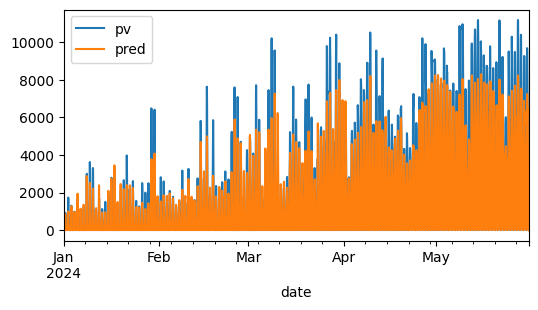

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


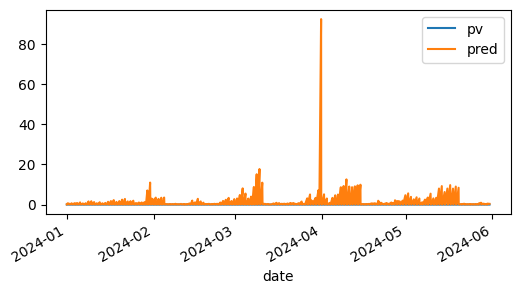

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

In [ ]:
def correct_pv_predictions(pred_pv, shortwave_radiation):
  return 0 if shortwave_radiation == 0 or pred_pv < 0 else pred_pv

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
predictions_pv_corrected = \
pd.DataFrame({'predictions_pv': predictions.pred, 'shortwave_radiation_t1': df_test.shortwave_radiation_t1})

predictions_pv_corrected['predictions_pv'] = \
predictions_pv_corrected.apply(lambda row: correct_pv_predictions(row.predictions_pv, row.shortwave_radiation_t1), axis = 1)

predictions_pv_corrected = predictions_pv_corrected['predictions_pv']
predictions_pv_corrected

2024-01-01 00:00:00+01:00       0.000000
2024-01-01 01:00:00+01:00       0.000000
2024-01-01 02:00:00+01:00       0.000000
2024-01-01 03:00:00+01:00       0.000000
2024-01-01 04:00:00+01:00       0.000000
                                ...     
2024-05-30 19:00:00+02:00    2230.552411
2024-05-30 20:00:00+02:00     940.444754
2024-05-30 21:00:00+02:00     265.120966
2024-05-30 22:00:00+02:00       0.000000
2024-05-30 23:00:00+02:00       0.000000
Freq: H, Name: predictions_pv, Length: 3623, dtype: float64

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(mean_squared_error(df_test.pv, predictions_pv_corrected)))
print("RMSE: " + str(mean_squared_error(df_test.pv, predictions_pv_corrected)**0.5))
print("MAE: " +  str(mean_absolute_error(df_test.pv, predictions_pv_corrected)))
print("Custom MAPE: " +  str(custom_mape(df_test.pv, predictions_pv_corrected)))
print("Custom sMAPE: " +  str(custom_smape(df_test.pv, predictions_pv_corrected)))

MSE: 677549.3582218727
RMSE: 823.1338640961583
MAE: 387.84232300876226
Custom MAPE: 0.1718801642243637
Custom sMAPE: 0.11392762385978446


In [ ]:
forecaster.fit(
    df_train['pv'],
    exog = df_train[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


feature  importance
28             terrestrial_radiation_t2    0.083352
0                                 lag_1    0.078516
48             terrestrial_radiation_t3    0.075052
34               shortwave_radiation_t1    0.065382
39       shortwave_radiation_instant_t1    0.064749
43     terrestrial_radiation_instant_t1    0.055504
23                               lag_24    0.054452
33     terrestrial_radiation_instant_t2    0.052821
38             terrestrial_radiation_t1    0.045834
24               shortwave_radiation_t2    0.045523
29       shortwave_radiation_instant_t2    0.040205
44               shortwave_radiation_t3    0.036978
40          direct_radiation_instant_t1    0.032306
49       shortwave_radiation_instant_t3    0.030965
35                  direct_radiation_t1    0.027841
46                 diffuse_radiation_t3    0.026475
36                 diffuse_radiation_t1    0.022766
50          direct_radiation_instant_t3    0.016165
26                 diffuse_radiation_t2    0.015670
41         diffuse_radiation_instant_t1    0.015646
30          direct_radiation_instant_t2    0.014733
25                  direct_radiation_t2    0.014688
22                               lag_23    0.013428
1                                 lag_2    0.012732
31         diffuse_radiation_instant_t2    0.008630
45                  direct_radiation_t3    0.008008
37          direct_normal_irradiance_t1    0.005744
47          direct_normal_irradiance_t3    0.005379
42  direct_normal_irradiance_instant_t1    0.005135
2                                 lag_3    0.004210
21                               lag_22    0.003645
27          direct_normal_irradiance_t2    0.003634
32  direct_normal_irradiance_instant_t2    0.002846
3                                 lag_4    0.002578
19                               lag_20    0.001625
20                               lag_21    0.001265
4                                 lag_5    0.000749
18                               lag_19    0.000716
5                                 lag_6    0.000661
17                               lag_18    0.000431
11                               lag_12    0.000398
6                                 lag_7    0.000360
9                                lag_10    0.000313
10                               lag_11    0.000283
12                               lag_13    0.000275
16                               lag_17    0.000268
13                               lag_14    0.000261
14                               lag_15    0.000240
7                                 lag_8    0.000221
15                               lag_16    0.000196
8                                 lag_9    0.000145

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


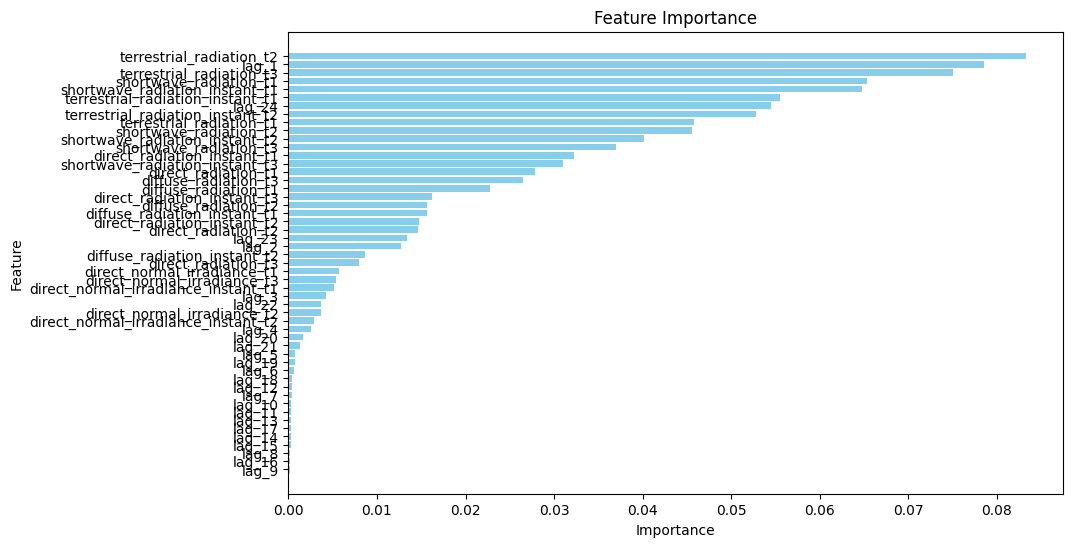

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

## 7.Not wind/pv generation

### 7.1. Recursive multi-step forecasting (with temp, dow, month, hour)

In [70]:
df_model['remainder'] = df_model['total'] - df_model['pv'] - df_model['wind']
df_train['remainder'] = df_train['total'] - df_train['pv'] - df_train['wind']
df_test['remainder'] = df_test['total'] - df_test['pv'] - df_test['wind']
df_model[['total', 'wind', 'pv', 'remainder']].head(10)

<ipython-input-70-4895875c903d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['remainder'] = df_train['total'] - df_train['pv'] - df_train['wind']
<ipython-input-70-4895875c903d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['remainder'] = df_test['total'] - df_test['pv'] - df_test['wind']


total      wind        pv  remainder
date                                                               
2023-01-01 01:00:00+01:00  14444.438  5529.188     0.000   8915.250
2023-01-01 02:00:00+01:00  13690.800  4250.700     0.000   9440.100
2023-01-01 03:00:00+01:00  13440.763  3124.613     0.000  10316.150
2023-01-01 04:00:00+01:00  13428.488  3486.663     0.000   9941.825
2023-01-01 05:00:00+01:00  13642.538  4257.800     0.000   9384.738
2023-01-01 06:00:00+01:00  13406.225  4474.250     0.000   8931.975
2023-01-01 07:00:00+01:00  13296.226  4497.025     0.000   8799.201
2023-01-01 08:00:00+01:00  13390.538  4565.875     7.825   8816.838
2023-01-01 09:00:00+01:00  13591.700  4338.200   351.125   8902.375
2023-01-01 10:00:00+01:00  14249.588  4223.313  1115.825   8910.450

#### 7.2.1. Random Forests

In [71]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['remainder'],
                          exog                  = df_model[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

In [72]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 5960652.872433992
RMSE: 2441.444832969607
MAE: 1920.1974074855093
MAPE: 0.14758568747582987
Custom MAPE: 0.14758568747582987
Custom sMAPE: 0.06861896198211408


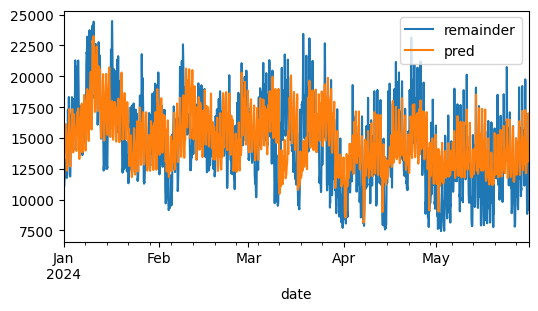

In [73]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['remainder'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [74]:
forecaster.fit(
    df_train['remainder'],
    exog = df_train[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']])
forecaster.get_feature_importances()

feature  importance
0                     lag_1    0.940767
1                     lag_2    0.012915
30                    hhour    0.007850
22                   lag_23    0.006266
2                     lag_3    0.004201
21                   lag_22    0.004056
20                   lag_21    0.001416
19                   lag_20    0.001301
18                   lag_19    0.001247
3                     lag_4    0.001202
9                    lag_10    0.001167
23                   lag_24    0.001115
4                     lag_5    0.001110
8                     lag_9    0.001110
28                      dow    0.001081
27  apparent_temperature_t3    0.001040
10                   lag_11    0.001023
13                   lag_14    0.001003
5                     lag_6    0.000989
26  apparent_temperature_t2    0.000983
7                     lag_8    0.000969
25  apparent_temperature_t1    0.000935
6                     lag_7    0.000881
12                   lag_13    0.000868
17                   lag_18    0.000819
14                   lag_15    0.000810
11                   lag_12    0.000762
15                   lag_16    0.000703
16                   lag_17    0.000692
29                   mmonth    0.000610
24                is_day_t1    0.000108

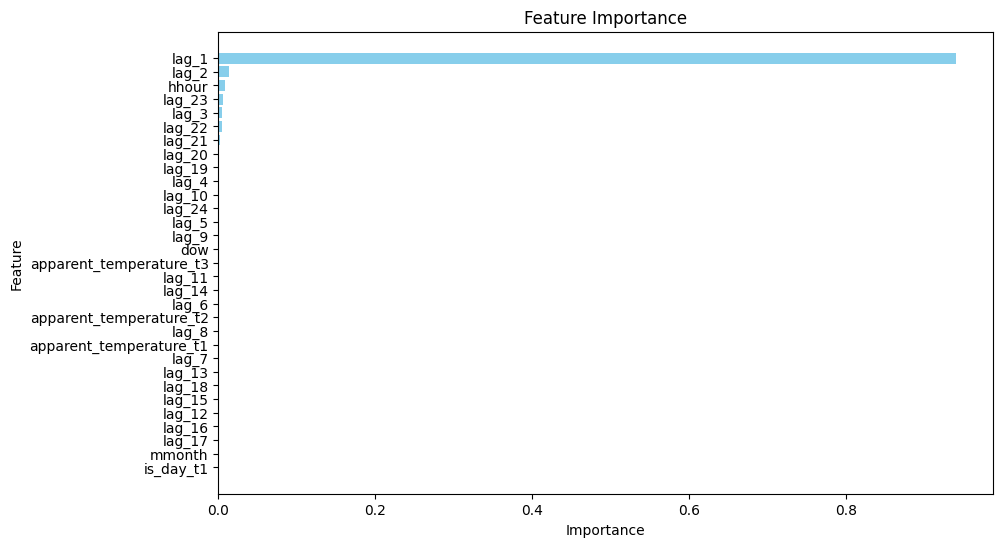

In [75]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 7.2.2. LightGBM

In [76]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['remainder'],
                          exog                  = df_model[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6931
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 31
[LightGBM] [Info] Start training from score 14725.466645


  0%|          | 0/50 [00:00<?, ?it/s]

In [77]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 3442919.6893391274
RMSE: 1855.5106276545891
MAE: 1443.662286597488
MAPE: 0.10890734589151825
Custom MAPE: 0.10890734589151825
Custom sMAPE: 0.051692797595342836


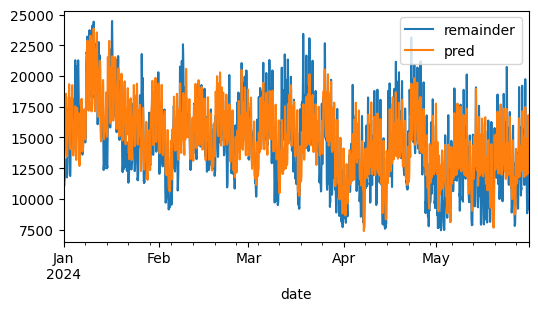

In [78]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['remainder'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [79]:
forecaster.fit(
    df_train['remainder'],
    exog = df_train[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']])
forecaster.get_feature_importances()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6931
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 31
[LightGBM] [Info] Start training from score 14725.466645


feature  importance
0                     lag_1         456
30                    hhour         439
1                     lag_2         205
28                      dow         131
21                   lag_22         115
2                     lag_3         107
22                   lag_23         106
23                   lag_24          96
25  apparent_temperature_t1          88
26  apparent_temperature_t2          82
8                     lag_9          77
29                   mmonth          76
27  apparent_temperature_t3          75
3                     lag_4          71
12                   lag_13          69
13                   lag_14          69
6                     lag_7          64
14                   lag_15          61
19                   lag_20          60
4                     lag_5          59
5                     lag_6          57
9                    lag_10          55
18                   lag_19          51
11                   lag_12          50
17                   lag_18          50
10                   lag_11          50
20                   lag_21          47
15                   lag_16          45
7                     lag_8          41
16                   lag_17          38
24                is_day_t1          10

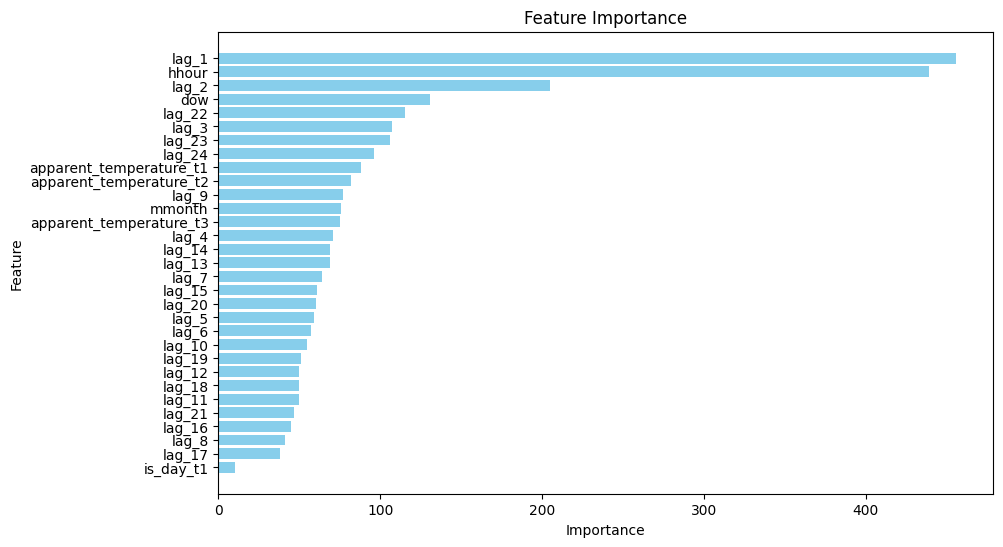

In [80]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 7.2.3. XGBoost

In [81]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['remainder'],
                          exog                  = df_model[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

In [82]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 3854894.6358558335
RMSE: 1963.3885595713941
MAE: 1542.6041774610558
MAPE: 0.11758853484741785
Custom MAPE: 0.11758853484741785
Custom sMAPE: 0.05555950643550026


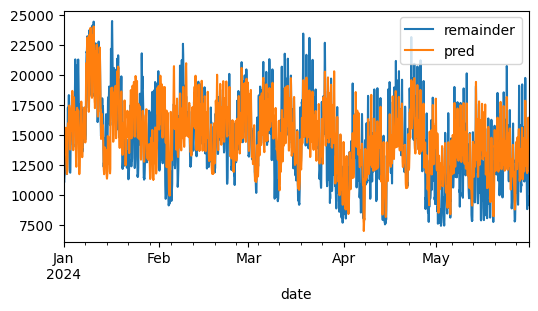

In [83]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['remainder'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [84]:
forecaster.fit(
    df_train['remainder'],
    exog = df_train[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']])
forecaster.get_feature_importances()

feature  importance
0                     lag_1    0.836630
30                    hhour    0.029153
1                     lag_2    0.020968
22                   lag_23    0.019041
21                   lag_22    0.014821
2                     lag_3    0.009724
28                      dow    0.009337
8                     lag_9    0.004205
19                   lag_20    0.004161
4                     lag_5    0.003221
9                    lag_10    0.003076
13                   lag_14    0.002926
29                   mmonth    0.002926
6                     lag_7    0.002847
18                   lag_19    0.002845
20                   lag_21    0.002712
14                   lag_15    0.002538
27  apparent_temperature_t3    0.002499
12                   lag_13    0.002352
15                   lag_16    0.002306
26  apparent_temperature_t2    0.002177
25  apparent_temperature_t1    0.002111
23                   lag_24    0.002100
16                   lag_17    0.002013
10                   lag_11    0.001978
11                   lag_12    0.001973
5                     lag_6    0.001937
7                     lag_8    0.001933
17                   lag_18    0.001921
24                is_day_t1    0.001822
3                     lag_4    0.001746

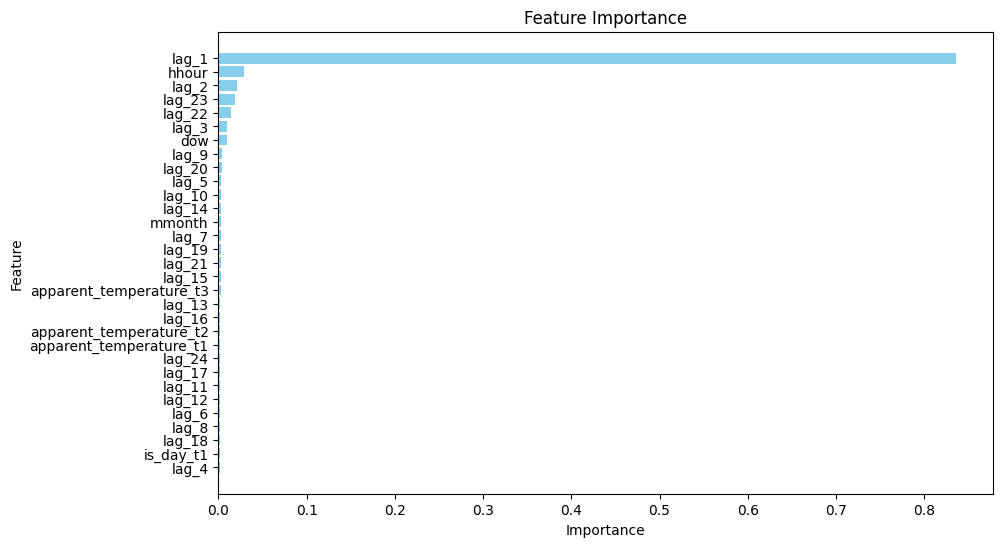

In [85]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 7.2.4. Optuna (LightGBM)

In [86]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1),
                 lags      = 24 # Placeholder, the value will be overwritten
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'             : trial.suggest_categorical('lags', [1, 3, 6, 12, 24]),
        'num_leaves'       : trial.suggest_int('num_leaves', 2, 256),
        'max_depth'        : trial.suggest_int('max_depth', -1, 16),
        'learning_rate'    : trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        'n_estimators'     : trial.suggest_int('n_estimators', 50, 1500),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight' : trial.suggest_float('min_child_weight', 1e-3, 1e2, log=True),
        'subsample'        : trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq'   : trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha'        : trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda'       : trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }

    return search_space

results, best_trial = bayesian_search_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['remainder'],
                          exog                  = df_model[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          search_space          = search_space,
                          steps                 = 24*3+1,
                          metric                = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error'],
                          refit                 = False,
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          n_trials              = 100,
                          random_state          = 123,
                          return_best           = True,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {},
                          output_file           = google_drive_path + "results_total_recursive_optuna_lightGBM.txt"
                      )

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-31 13:18:50,029] Trial 0 finished with value: 1579.2428787340345 and parameters: {'lags': 24, 'num_leaves': 109, 'max_depth': 16, 'learning_rate': 0.05486797781181634, 'n_estimators': 747, 'min_child_samples': 42, 'min_child_weight': 0.051986440302397775, 'subsample': 0.7561447366456374, 'subsample_freq': 4, 'colsample_bytree': 0.15371010694861154, 'reg_alpha': 1.528811858152725e-05, 'reg_lambda': 0.008016102206099943}. Best is trial 0 with value: 1579.2428787340345.
[I 2024-07-31 13:18:59,917] Trial 1 finished with value: 1436.8776884513236 and parameters: {'lags': 24, 'num_leaves': 218, 'max_depth': 12, 'learning_rate': 0.02780315255778501, 'n_estimators': 1098, 'min_child_samples': 36, 'min_child_weight': 0.06440851380101245, 'subsample': 0.30543690779106003, 'subsample_freq': 3, 'colsample_bytree': 0.667878511469039, 'reg_alpha': 5.455562299744123e-08, 'reg_lambda': 2.9485560066017848e-05}. Best is trial 1 with value: 1436.8776884513236.
[I 2024-07-31 13:19:08,381] Trial

In [87]:
# Print the best hyperparameters
print(best_trial.params)
print(best_trial.value)

{'lags': 12, 'num_leaves': 85, 'max_depth': 8, 'learning_rate': 0.011952880722955372, 'n_estimators': 1017, 'min_child_samples': 83, 'min_child_weight': 12.87049894681169, 'subsample': 0.6339586817775121, 'subsample_freq': 8, 'colsample_bytree': 0.6529808015249932, 'reg_alpha': 3.644607522209518e-08, 'reg_lambda': 0.17760947197632568}
1358.6012271930365


In [88]:
params = { 'num_leaves': 85, 'max_depth': 8, 'learning_rate': 0.011952880722955372, 'n_estimators': 1017, 'min_child_samples': 83,
          'min_child_weight': 12.87049894681169, 'subsample': 0.6339586817775121, 'subsample_freq': 8, 'colsample_bytree': 0.6529808015249932,
           'reg_alpha': 3.644607522209518e-08, 'reg_lambda': 0.17760947197632568}

# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, **params),
                 lags      = 12
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['remainder'],
                          exog                  = df_model[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

In [89]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 3022765.3236708287
RMSE: 1738.6101701275156
MAE: 1358.6012271930365
MAPE: 0.10263289273002144
Custom MAPE: 0.10263289273002144
Custom sMAPE: 0.04885765846450527


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


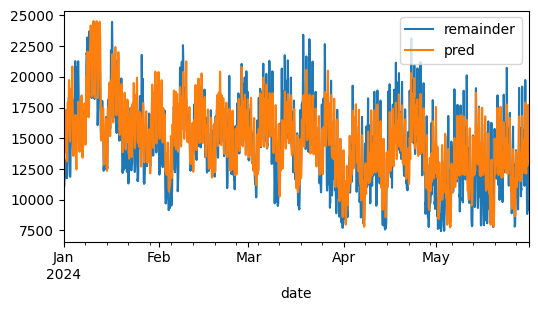

In [90]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['remainder'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [91]:
forecaster.fit(
    df_train['remainder'],
    exog = df_train[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']])
forecaster.get_feature_importances()

feature  importance
0                     lag_1        5413
18                    hhour        4336
1                     lag_2        4239
2                     lag_3        2202
11                   lag_12        1715
3                     lag_4        1521
15  apparent_temperature_t3        1434
4                     lag_5        1372
13  apparent_temperature_t1        1325
10                   lag_11        1261
9                    lag_10        1258
17                   mmonth        1257
14  apparent_temperature_t2        1222
5                     lag_6        1188
8                     lag_9        1165
16                      dow        1154
6                     lag_7        1112
7                     lag_8        1103
12                is_day_t1         289

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


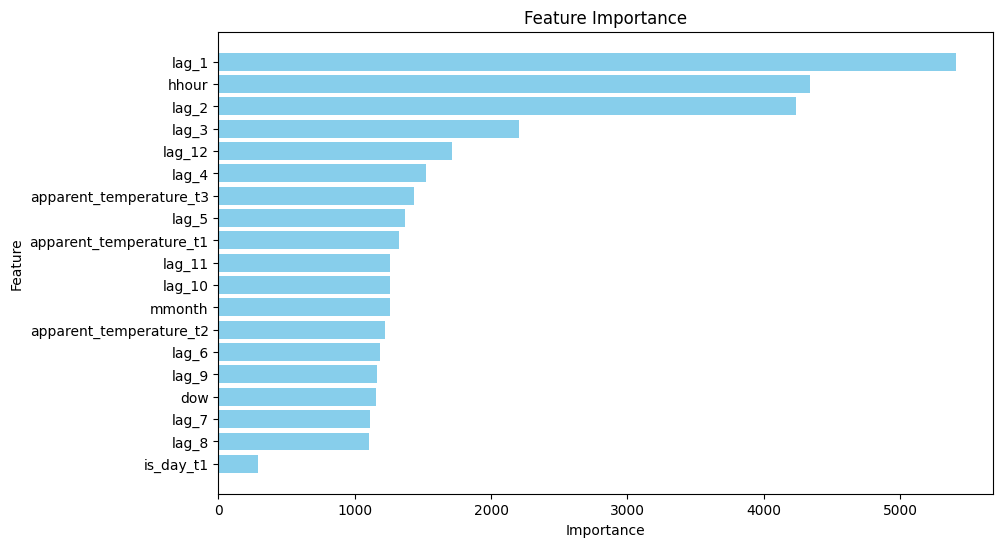

In [92]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

## 8.Performance Evaluation

In [97]:
df_model_last_fit = df_model.copy()
df_model_last_fit = df_model_last_fit[df_model_last_fit.index >= pd.Timestamp('2023-05-31 00:00:00', tz='Europe/Warsaw')]
df_model_last_fit['remainder'] = df_model_last_fit['total'] - df_model_last_fit['pv'] - df_model_last_fit['wind']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 8.1. Best wind model

In [17]:
params = {'num_leaves': 84, 'max_depth': 8, 'learning_rate': 0.009097938305291233, 'n_estimators': 989, 'min_child_samples': 34,
          'min_child_weight': 0.0804821134687246, 'subsample': 0.18950167237932425, 'subsample_freq': 6, 'colsample_bytree': 0.3725844705156614,
          'reg_alpha': 0.0009952481728406233, 'reg_lambda': 6.040076238725712e-05}

# Backtesting forecaster
# ==============================================================================
forecaster_wind = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, **params),
                 lags      = 2
             )

metric, predictions_wind = backtesting_forecaster(
                          forecaster            = forecaster_wind,
                          y                     = df_model['wind'],
                          exog                  = df_model[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                                                            'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                                                            'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

In [18]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 381135.0539015295
RMSE: 617.3613641146727
MAE: 471.91953527866707
MAPE: 0.2109849152776022
Custom MAPE: 0.2109849152776022
Custom sMAPE: 0.10858496591933176


In [19]:
def correct_wind_predictions(pred_wind):
  pred_wind.pred = pred_wind.pred.apply(lambda x: 0 if x < 0 else x)
  return pred_wind.pred

In [23]:
predictions_wind_corrected = correct_wind_predictions(predictions_wind)

In [24]:
# Backtest error
# ==============================================================================
print("MSE: " + str(mean_squared_error(df_test.wind, predictions_wind_corrected)))
print("RMSE: " + str(mean_squared_error(df_test.wind, predictions_wind_corrected)**0.5))
print("MAE: " +  str(mean_absolute_error(df_test.wind, predictions_wind_corrected)))
print("Custom MAPE: " +  str(custom_mape(df_test.wind, predictions_wind_corrected)))
print("Custom sMAPE: " +  str(custom_smape(df_test.wind, predictions_wind_corrected)))

MSE: 381135.0539015295
RMSE: 617.3613641146727
MAE: 471.91953527866707
Custom MAPE: 0.2109849152776022
Custom sMAPE: 0.10858496591933176


In [25]:
forecaster_wind.fit(
    df_model_last_fit['wind'],
    exog = df_model_last_fit[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                              'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                              'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']])

In [26]:
save_forecaster(forecaster_wind, file_name='forecaster_pl_wind.joblib', verbose=False)

### 8.2. Best total model

In [28]:
params = { 'num_leaves': 44, 'max_depth': 11, 'learning_rate': 0.006857266832854931, 'n_estimators': 721, 'min_child_samples': 13,
'min_child_weight': 0.03314197175238346, 'subsample': 0.6845684084457395, 'subsample_freq': 1, 'colsample_bytree': 0.9999577589484245,
           'reg_alpha': 0.00037359713404698947, 'reg_lambda': 5.217052797174865e-06}

# Backtesting forecaster
# ==============================================================================
forecaster_total = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, **params),
                 lags      = 1
             )

metric, predictions_total = backtesting_forecaster(
                          forecaster            = forecaster_total,
                          y                     = df_model['total'],
                          exog                  = df_model[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

In [29]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1731463.7213595088
RMSE: 1315.8509495225926
MAE: 995.1409925919507
MAPE: 0.05333233503027261
Custom MAPE: 0.05333233503027261
Custom sMAPE: 0.026301594666925717


In [30]:
forecaster_total.fit(
    df_model_last_fit['total'],
    exog = df_model_last_fit[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']])

In [31]:
save_forecaster(forecaster_total, file_name='forecaster_pl_total.joblib', verbose=False)

### 8.3. Best PV model

In [32]:
params = {'num_leaves': 82, 'max_depth': 9, 'learning_rate': 0.018413051014594402, 'n_estimators': 385, 'min_child_samples': 38,
          'min_child_weight': 1.3142102071351776, 'subsample': 0.9502289556651793, 'subsample_freq': 3, 'colsample_bytree': 0.2698590364747545,
          'reg_alpha': 7.56182988136327e-08, 'reg_lambda': 8.031715375361947e-06}


# Backtesting forecaster
# ==============================================================================
forecaster_pv = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, **params),
                 lags      = 3
             )

metric, predictions_pv = backtesting_forecaster(
                          forecaster            = forecaster_pv,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

In [33]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 647536.4818715804
RMSE: 804.696515384266
MAE: 389.52973797564835
MAPE: 3919951789951364.5
Custom MAPE: 0.5876216052276847
Custom sMAPE: 0.5206606840592327


In [34]:
def correct_pv_predictions(pred_pv, shortwave_radiation):
  return 0 if shortwave_radiation == 0 or pred_pv < 0 else pred_pv

In [36]:
predictions_pv_corrected = \
pd.DataFrame({'predictions_pv': predictions_pv.pred, 'shortwave_radiation_t1': df_test.shortwave_radiation_t1})

predictions_pv_corrected['predictions_pv'] = \
predictions_pv_corrected.apply(lambda row: correct_pv_predictions(row.predictions_pv, row.shortwave_radiation_t1), axis = 1)

predictions_pv_corrected = predictions_pv_corrected['predictions_pv']
predictions_pv_corrected

2024-01-01 00:00:00+01:00       0.000000
2024-01-01 01:00:00+01:00       0.000000
2024-01-01 02:00:00+01:00       0.000000
2024-01-01 03:00:00+01:00       0.000000
2024-01-01 04:00:00+01:00       0.000000
                                ...     
2024-05-30 19:00:00+02:00    1894.228307
2024-05-30 20:00:00+02:00     722.766989
2024-05-30 21:00:00+02:00     216.705308
2024-05-30 22:00:00+02:00       0.000000
2024-05-30 23:00:00+02:00       0.000000
Freq: H, Name: predictions_pv, Length: 3623, dtype: float64

In [37]:
# Backtest error
# ==============================================================================
print("MSE: " + str(mean_squared_error(df_test.pv, predictions_pv_corrected)))
print("RMSE: " + str(mean_squared_error(df_test.pv, predictions_pv_corrected)**0.5))
print("MAE: " +  str(mean_absolute_error(df_test.pv, predictions_pv_corrected)))
print("Custom MAPE: " +  str(custom_mape(df_test.pv, predictions_pv_corrected)))
print("Custom sMAPE: " +  str(custom_smape(df_test.pv, predictions_pv_corrected)))

MSE: 647604.0829683035
RMSE: 804.7385183824019
MAE: 389.4356111352659
Custom MAPE: 0.17204666318331316
Custom sMAPE: 0.11834459138363114


In [38]:
forecaster_pv.fit(
    df_model_last_fit['pv'],
    exog = df_model_last_fit[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [39]:
save_forecaster(forecaster_pv, file_name='forecaster_pl_pv.joblib', verbose=False)

### 8.4. Best Remainder Model

In [93]:
params = { 'num_leaves': 85, 'max_depth': 8, 'learning_rate': 0.011952880722955372, 'n_estimators': 1017, 'min_child_samples': 83,
          'min_child_weight': 12.87049894681169, 'subsample': 0.6339586817775121, 'subsample_freq': 8, 'colsample_bytree': 0.6529808015249932,
           'reg_alpha': 3.644607522209518e-08, 'reg_lambda': 0.17760947197632568}

# Backtesting forecaster
# ==============================================================================
forecaster_remainder = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, **params),
                 lags      = 12
             )

metric, predictions_remainder = backtesting_forecaster(
                          forecaster            = forecaster_remainder,
                          y                     = df_model['remainder'],
                          exog                  = df_model[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3+1,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 3022765.3236708287
RMSE: 1738.6101701275156
MAE: 1358.6012271930365
MAPE: 0.10263289273002144
Custom MAPE: 0.10263289273002144
Custom sMAPE: 0.04885765846450527


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [99]:
forecaster_remainder.fit(
    df_model_last_fit['remainder'],
    exog = df_model_last_fit[['is_day_t1', 'apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']])

In [101]:
save_forecaster(forecaster_remainder, file_name='forecaster_pl_remainder.joblib', verbose=False)

# How to predict:
- Needs lags based on the lags the model was trained
- Needs exogenous parameters the same number as the steps ahead to be forecasted
- Both should be indexed based on datetimes

In [ ]:
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, num_leaves = 126, max_depth = 16, learning_rate = 0.006560371025154591,
                                           n_estimators = 877, min_child_samples = 95, min_child_weight = 0.006273241404256478, subsample = 0.6423580505833233,
                                           subsample_freq = 7, colsample_bytree = 0.2007842480609956, reg_alpha = 0.0003656058725013657,
                                           reg_lambda = 1.7710459138844433e-06, verbose = -1),
                 lags      = 2
             )

In [ ]:
forecaster.fit(df_train['pv'],
               exog = df_train[['apparent_temperature_pv1']])

In [ ]:
# Creating an hourly date range
hourly_date_range = pd.date_range(start='2024-06-30', periods=24, freq='H')

# Creating the Series
pv_series = pd.Series(
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
    index=hourly_date_range,
    name='pv'
).tail(2)
pv_series

2024-06-30 22:00:00    23
2024-06-30 23:00:00    24
Freq: H, Name: pv, dtype: int64

In [ ]:
hourly_date_range = pd.date_range(start='2024-07-01', periods=3, freq='H')

df = pd.DataFrame({
    'apparent_temperature_pv1': [21, 22, 23]
}, index = hourly_date_range)
df

apparent_temperature_pv1
2024-07-01 00:00:00                        21
2024-07-01 01:00:00                        22
2024-07-01 02:00:00                        23

In [ ]:
forecaster.predict(steps = 3, exog = df.head(3), last_window = pv_series.tail(2) )

2024-07-01 00:00:00    57.901594
2024-07-01 01:00:00    70.404865
2024-07-01 02:00:00    80.551832
Freq: H, Name: pred, dtype: float64